In [30]:
!pip install yfinance

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D

Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'retina'

In [0]:
start_date = '2016-02-01'
end_date = '2019-12-31'

In [0]:
data = yfinance.download("AUDUSD=X CADUSD=X CHFUSD=X \
                          CNYUSD=X DKKUSD=X EURUSD=X \
                          GBPUSD=X HKDUSD=X JPYUSD=X \
                          KZTUSD=X NOKUSD=X NZDUSD=X \
                          PLNUSD=X RUBUSD=X SEKUSD=X",
                        start=start_date, end=end_date)

[*********************100%***********************]  15 of 15 completed


In [0]:
data['Close'].head()

AUDUSD=X  CADUSD=X  CHFUSD=X  ...  PLNUSD=X  RUBUSD=X  SEKUSD=X
Date                                      ...                              
2016-02-01  0.706864  0.715676  0.976086  ...  0.245228  0.013256  0.116426
2016-02-02  0.711086  0.716846  0.980873  ...  0.247986  0.012943  0.117306
2016-02-03  0.702988  0.711238  0.981653  ...  0.248004  0.012545  0.116964
2016-02-04  0.715461  0.724942  0.994827  ...  0.251062  0.012999  0.118491
2016-02-05  0.719942  0.726998  1.006654  ...  0.253291  0.013026  0.119067

[5 rows x 15 columns]

In [0]:
data['Close'].describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
new_data = data['Close'].interpolate(method='polynomial', order=3)

In [0]:
new_data.describe()

AUDUSD=X     CADUSD=X  ...     RUBUSD=X     SEKUSD=X
count  1019.000000  1019.000000  ...  1019.000000  1019.000000
mean      0.739233     0.764229  ...     0.015967     0.113791
std       0.033680     0.019115  ...     0.001051     0.006508
min       0.670808     0.711238  ...     0.012536     0.100556
25%       0.712078     0.751233  ...     0.015258     0.108809
50%       0.744879     0.761087  ...     0.015713     0.113203
75%       0.764030     0.775518  ...     0.016910     0.119123
max       0.811688     0.825948  ...     0.017976     0.127521

[8 rows x 15 columns]

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [0]:
# new_data['day'] = new_data.index.day
# new_data['month'] = new_data.index.month

In [0]:
values = new_data.values
values

array([[0.70686364, 0.71567619, 0.9760859 , ..., 0.24522787, 0.01325557,
        0.11642582],
       [0.71108586, 0.71684587, 0.98087299, ..., 0.24798575, 0.01294331,
        0.11730605],
       [0.70298767, 0.71123755, 0.98165292, ..., 0.24800359, 0.01254469,
        0.1169644 ],
       ...,
       [0.69463742, 0.7628929 , 1.01887989, ..., 0.26060671, 0.01608338,
        0.10633377],
       [0.69829965, 0.76491195, 1.02699983, ..., 0.26248854, 0.01611572,
        0.10722665],
       [0.70013791, 0.76566166, 1.03238595, ..., 0.26333806, 0.01613655,
        0.10701276]])

In [0]:
values.shape

(1019, 15)

In [0]:
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [0]:
scaled

array([[0.25593185, 0.0386939 , 0.0439291 , ..., 0.15635943, 0.1321969 ,
        0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , ..., 0.19794154, 0.07479477,
        0.62116647],
       [0.2284193 , 0.        , 0.09297752, ..., 0.19821048, 0.00151777,
        0.6084964 ],
       ...,
       [0.16914749, 0.4503107 , 0.42097282, ..., 0.38823485, 0.65202737,
        0.21426368],
       [0.19514275, 0.46791172, 0.4925146 , ..., 0.41660833, 0.65797377,
        0.24737573],
       [0.2081914 , 0.47444773, 0.5399704 , ..., 0.42941713, 0.66180277,
        0.23944402]], dtype=float32)

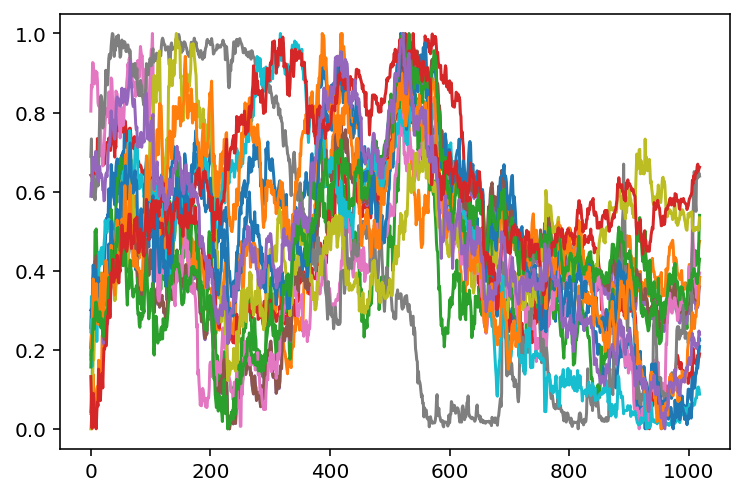

In [0]:
plt.plot(scaled)
plt.show()

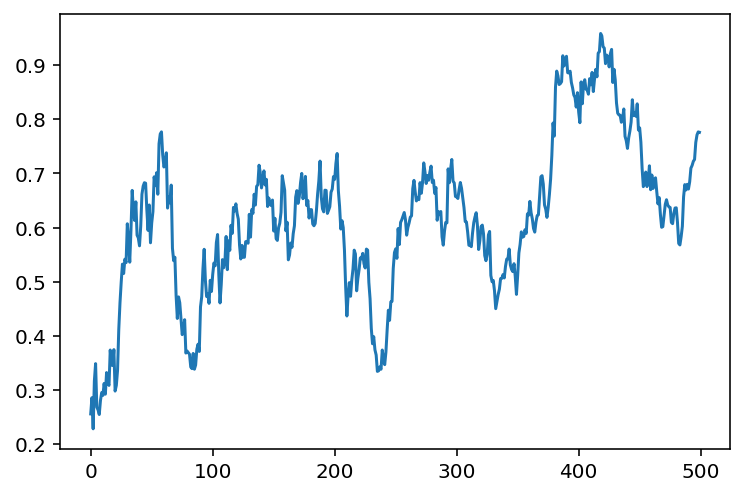

In [0]:
plt.plot(scaled[:,0][0:500])

In [43]:
# specify the number of lag hours
n_hours = 15
n_features = scaled.shape[1]
n_predict = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, n_predict)
print(reframed.shape)

(1004, 240)


In [44]:
reframed.head()

var1(t-15)  var2(t-15)  var3(t-15)  ...  var13(t)  var14(t)  var15(t)
15    0.255932    0.038694    0.043929  ...  0.296232  0.071412  0.663507
16    0.285902    0.048891    0.086106  ...  0.274866  0.071412  0.635841
17    0.228419    0.000000    0.092978  ...  0.255027  0.111063  0.645630
18    0.316959    0.119473    0.209049  ...  0.259227  0.122705  0.639646
19    0.348768    0.137392    0.313253  ...  0.278317  0.140624  0.635430

[5 rows x 240 columns]

In [0]:
# split into train and test sets
values = reframed.values
n_train_hours = 500
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [0]:
# split into input and outputs
n_obs = n_hours * n_features

In [47]:
train_X, train_y = train[:, :n_obs], train[:, n_obs:]
test_X, test_y = test[:, :n_obs], test[:, n_obs:]
print(train_X.shape, train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(500, 225) (500, 15)
(500, 15, 15) (500, 15) (504, 15, 15) (504, 15)


In [0]:
train_X[0]

array([[0.25593185, 0.0386939 , 0.0439291 , 0.64156723, 0.18777752,
        0.20543861, 0.8036547 , 0.68912506, 0.        , 0.24512935,
        0.30025148, 0.1762433 , 0.15635943, 0.1321969 , 0.5885236 ],
       [0.28590202, 0.04889107, 0.0861063 , 0.63893175, 0.22134686,
        0.23911333, 0.86938477, 0.7333145 , 0.01928616, 0.3348639 ,
        0.30319977, 0.23539543, 0.19794154, 0.07479477, 0.62116647]],
      dtype=float32)

In [0]:
train_y[0]

array([0.2284193 , 0.        , 0.09297752, 0.6373286 , 0.23259163,
       0.25079298, 0.8626237 , 0.5869827 , 0.05771112, 0.15758896,
       0.28015852, 0.21541405, 0.19821048, 0.00151777, 0.6084964 ],
      dtype=float32)

In [0]:
values[:,0][0:n_hours+n_predict]

array([0.25593185, 0.28590202, 0.2284193 ], dtype=float32)

In [0]:
train_X.shape

(500, 2, 15)

In [0]:
# design network
model = Sequential()
model.add(Dense(128, input_shape=(train_X.shape[1], train_X.shape[2]), activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Flatten())
model.add(Dense(train_y.shape[1], activation='linear'))
model.compile(loss='mse', optimizer='adam')

In [0]:
model = Sequential()
model.add(Conv2D(128, (2,2) ,input_shape=(train_X.shape[1], train_X.shape[2], 1), activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (2, 2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (2, 2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(train_y.shape[1],activation='relu'))

model.compile(loss='mse', optimizer='adam')

In [0]:
train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1).shape

(500, 30, 15, 1)

Train on 500 samples, validate on 504 samples
Epoch 1/100
 - 1s - loss: 0.2463 - val_loss: 0.1134
Epoch 2/100
 - 0s - loss: 0.1759 - val_loss: 0.0871
Epoch 3/100
 - 0s - loss: 0.1521 - val_loss: 0.0901
Epoch 4/100
 - 0s - loss: 0.1357 - val_loss: 0.0820
Epoch 5/100
 - 0s - loss: 0.1229 - val_loss: 0.0661
Epoch 6/100
 - 0s - loss: 0.1170 - val_loss: 0.0639
Epoch 7/100
 - 0s - loss: 0.1047 - val_loss: 0.0675
Epoch 8/100
 - 0s - loss: 0.0976 - val_loss: 0.0649
Epoch 9/100
 - 0s - loss: 0.0925 - val_loss: 0.0584
Epoch 10/100
 - 0s - loss: 0.0870 - val_loss: 0.0543
Epoch 11/100
 - 0s - loss: 0.0833 - val_loss: 0.0525
Epoch 12/100
 - 0s - loss: 0.0771 - val_loss: 0.0509
Epoch 13/100
 - 0s - loss: 0.0760 - val_loss: 0.0488
Epoch 14/100
 - 0s - loss: 0.0758 - val_loss: 0.0486
Epoch 15/100
 - 0s - loss: 0.0738 - val_loss: 0.0477
Epoch 16/100
 - 0s - loss: 0.0708 - val_loss: 0.0456
Epoch 17/100
 - 0s - loss: 0.0693 - val_loss: 0.0461
Epoch 18/100
 - 0s - loss: 0.0682 - val_loss: 0.0452
Epoch 19/

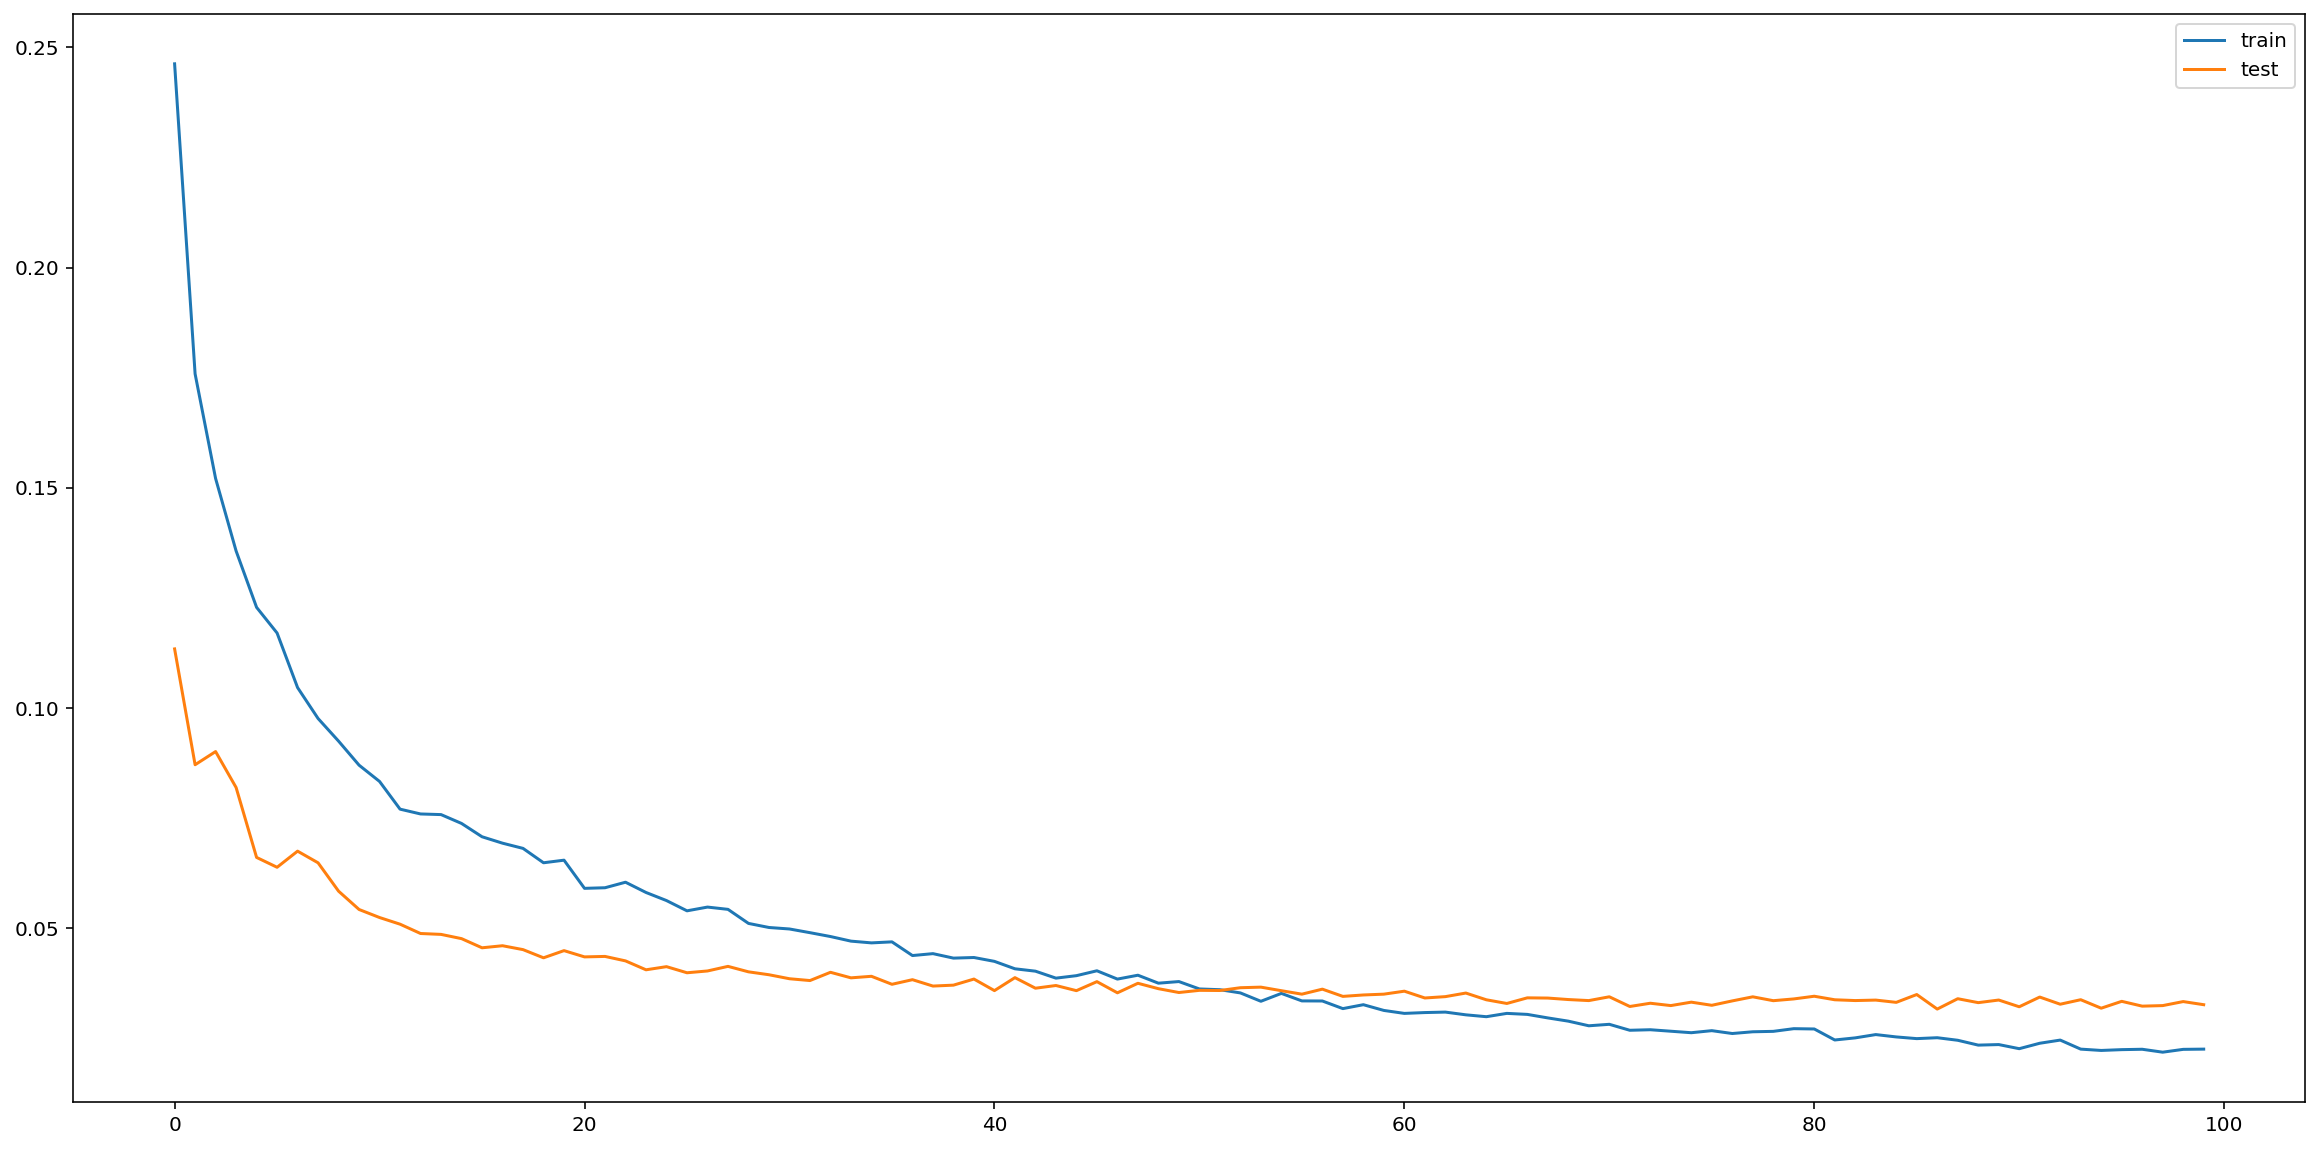

In [49]:
# fit network
#history = model.fit(train_X, train_y, epochs=100, batch_size=128, validation_data=(test_X, test_y), verbose=2, shuffle=False)
history = model.fit(train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1), train_y, epochs=100, batch_size=128, validation_data=(test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1), test_y), verbose=2, shuffle=False)
# plot history
fig, ax = plt.subplots(figsize=(20,10))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [0]:
y_hat = scaler.inverse_transform(test_y)
#y_pred = scaler.inverse_transform(model.predict(test_X))
y_pred = scaler.inverse_transform(model.predict(test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)))

In [51]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(y_hat[:, i], color='green')
    plt.plot(y_pred[:, i], color='red')
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [52]:
!pip install ml_metrics

  Created wheel for ml-metrics: filename=ml_metrics-0.1.4-cp36-none-any.whl size=7850 sha256=2823188c9b4082cbcb129c8fe5691430023cb4adf4adbc6bcb1f8b7bd85aca4f
  Stored in directory: /root/.cache/pip/wheels/b3/61/2d/776be7b8a4f14c5db48c8e5451451cabc58dc6aa7ee3801163
Successfully built ml-metrics


In [0]:
import ml_metrics as metrics

In [55]:
metrics.rmse(y_hat[:, -2], y_pred[:, -2])

0.0007582172

In [56]:
metrics.mae(y_hat[:, -2], y_pred[:, -2])

0.00060865283

In [0]:
def predict(start_arr, dist):
    res = np.array(start_arr)[:,0:n_features]
    
    for i in range(dist):
        pred = model.predict(np.array([res[-n_hours:]])).reshape(n_predict,n_features)
        res = np.concatenate((res, pred))
        if len(res) > dist + len(start_arr):
            break
    
    return res

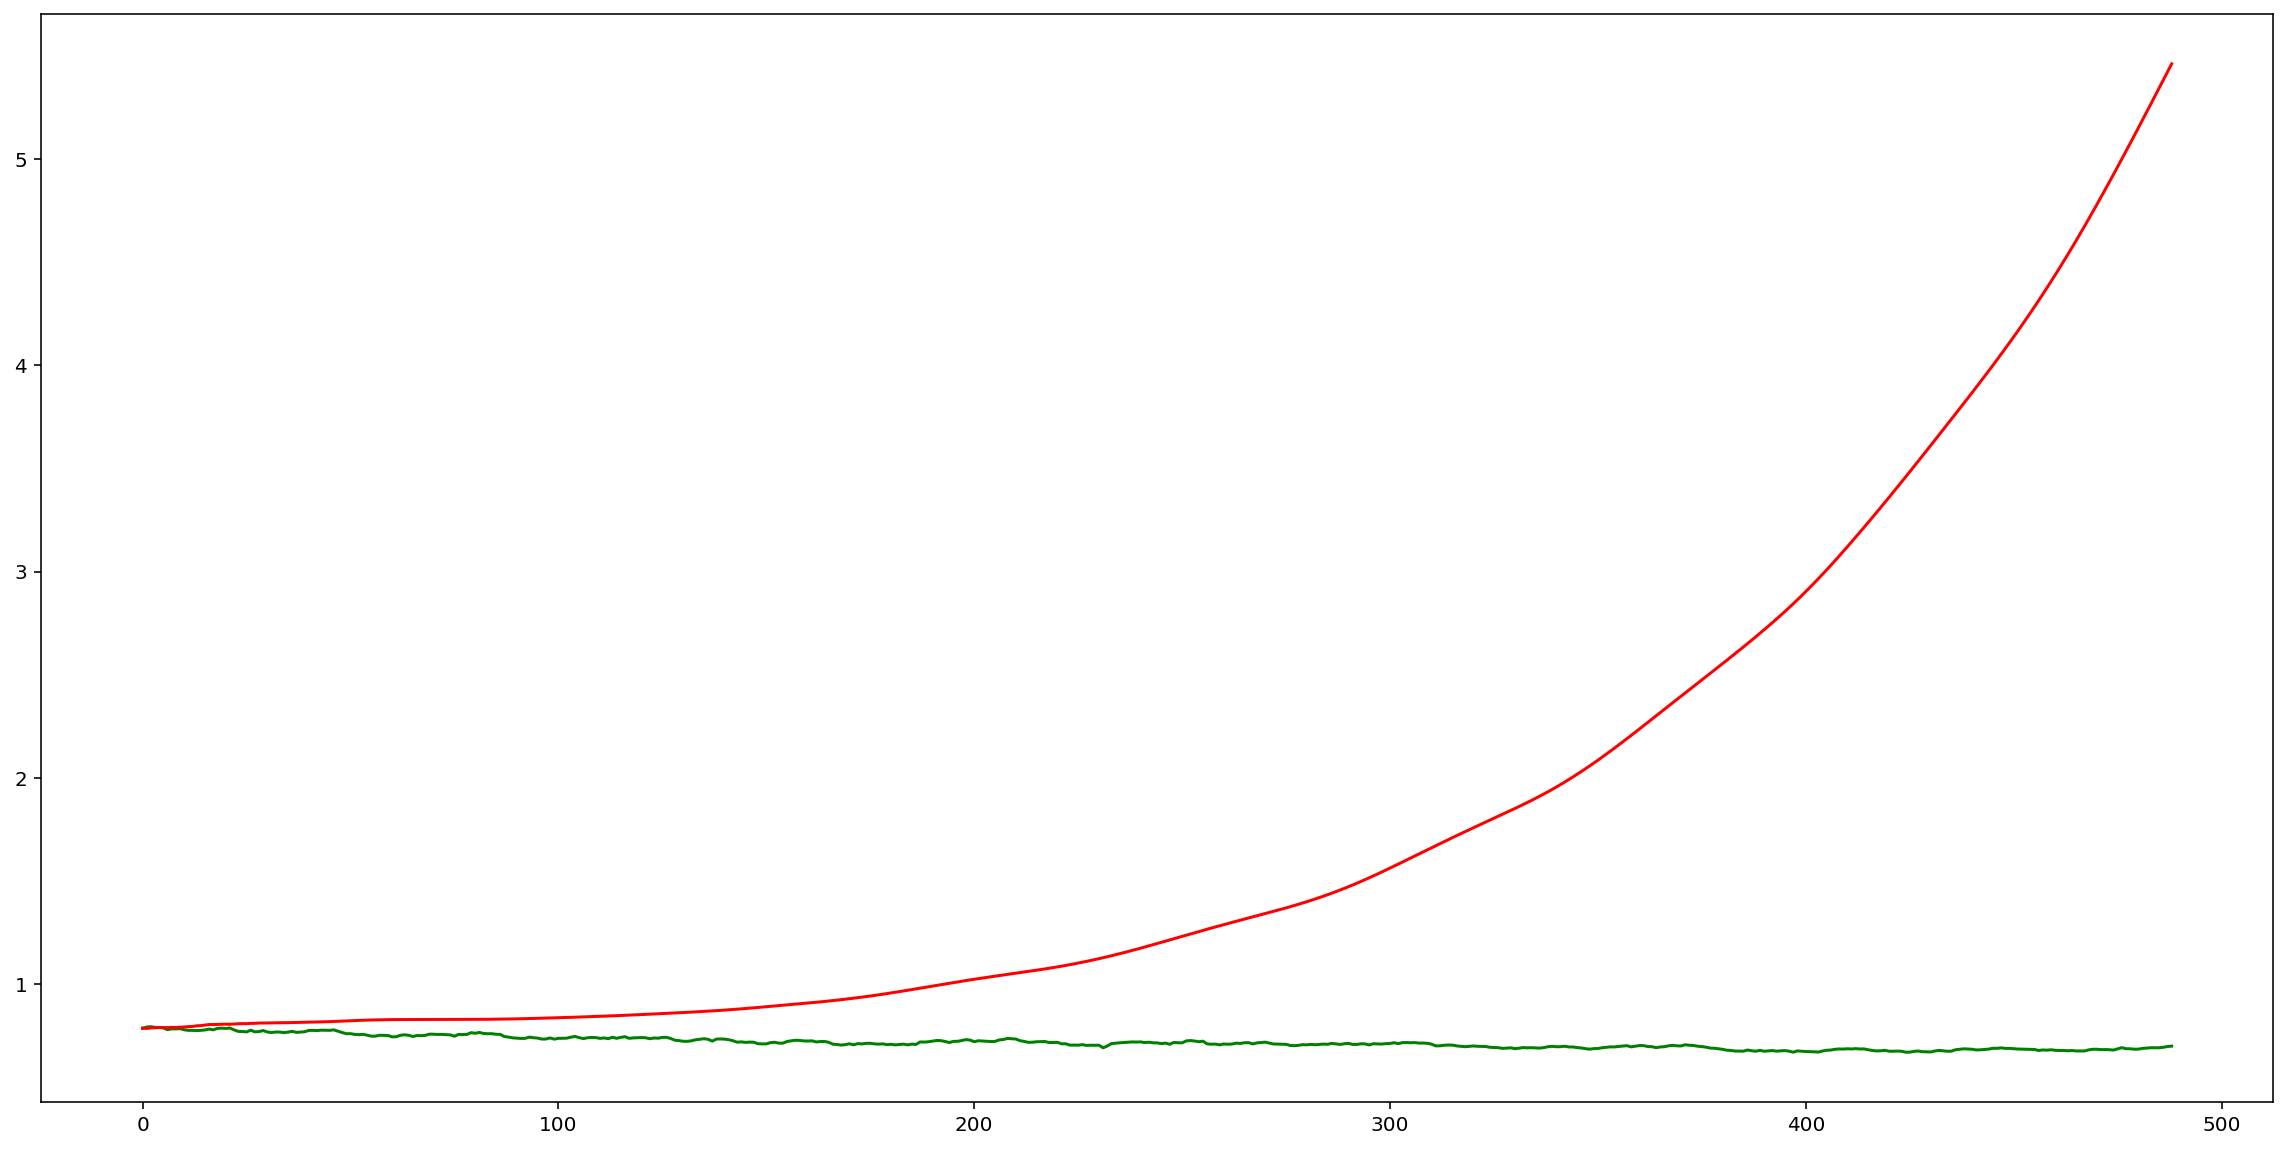

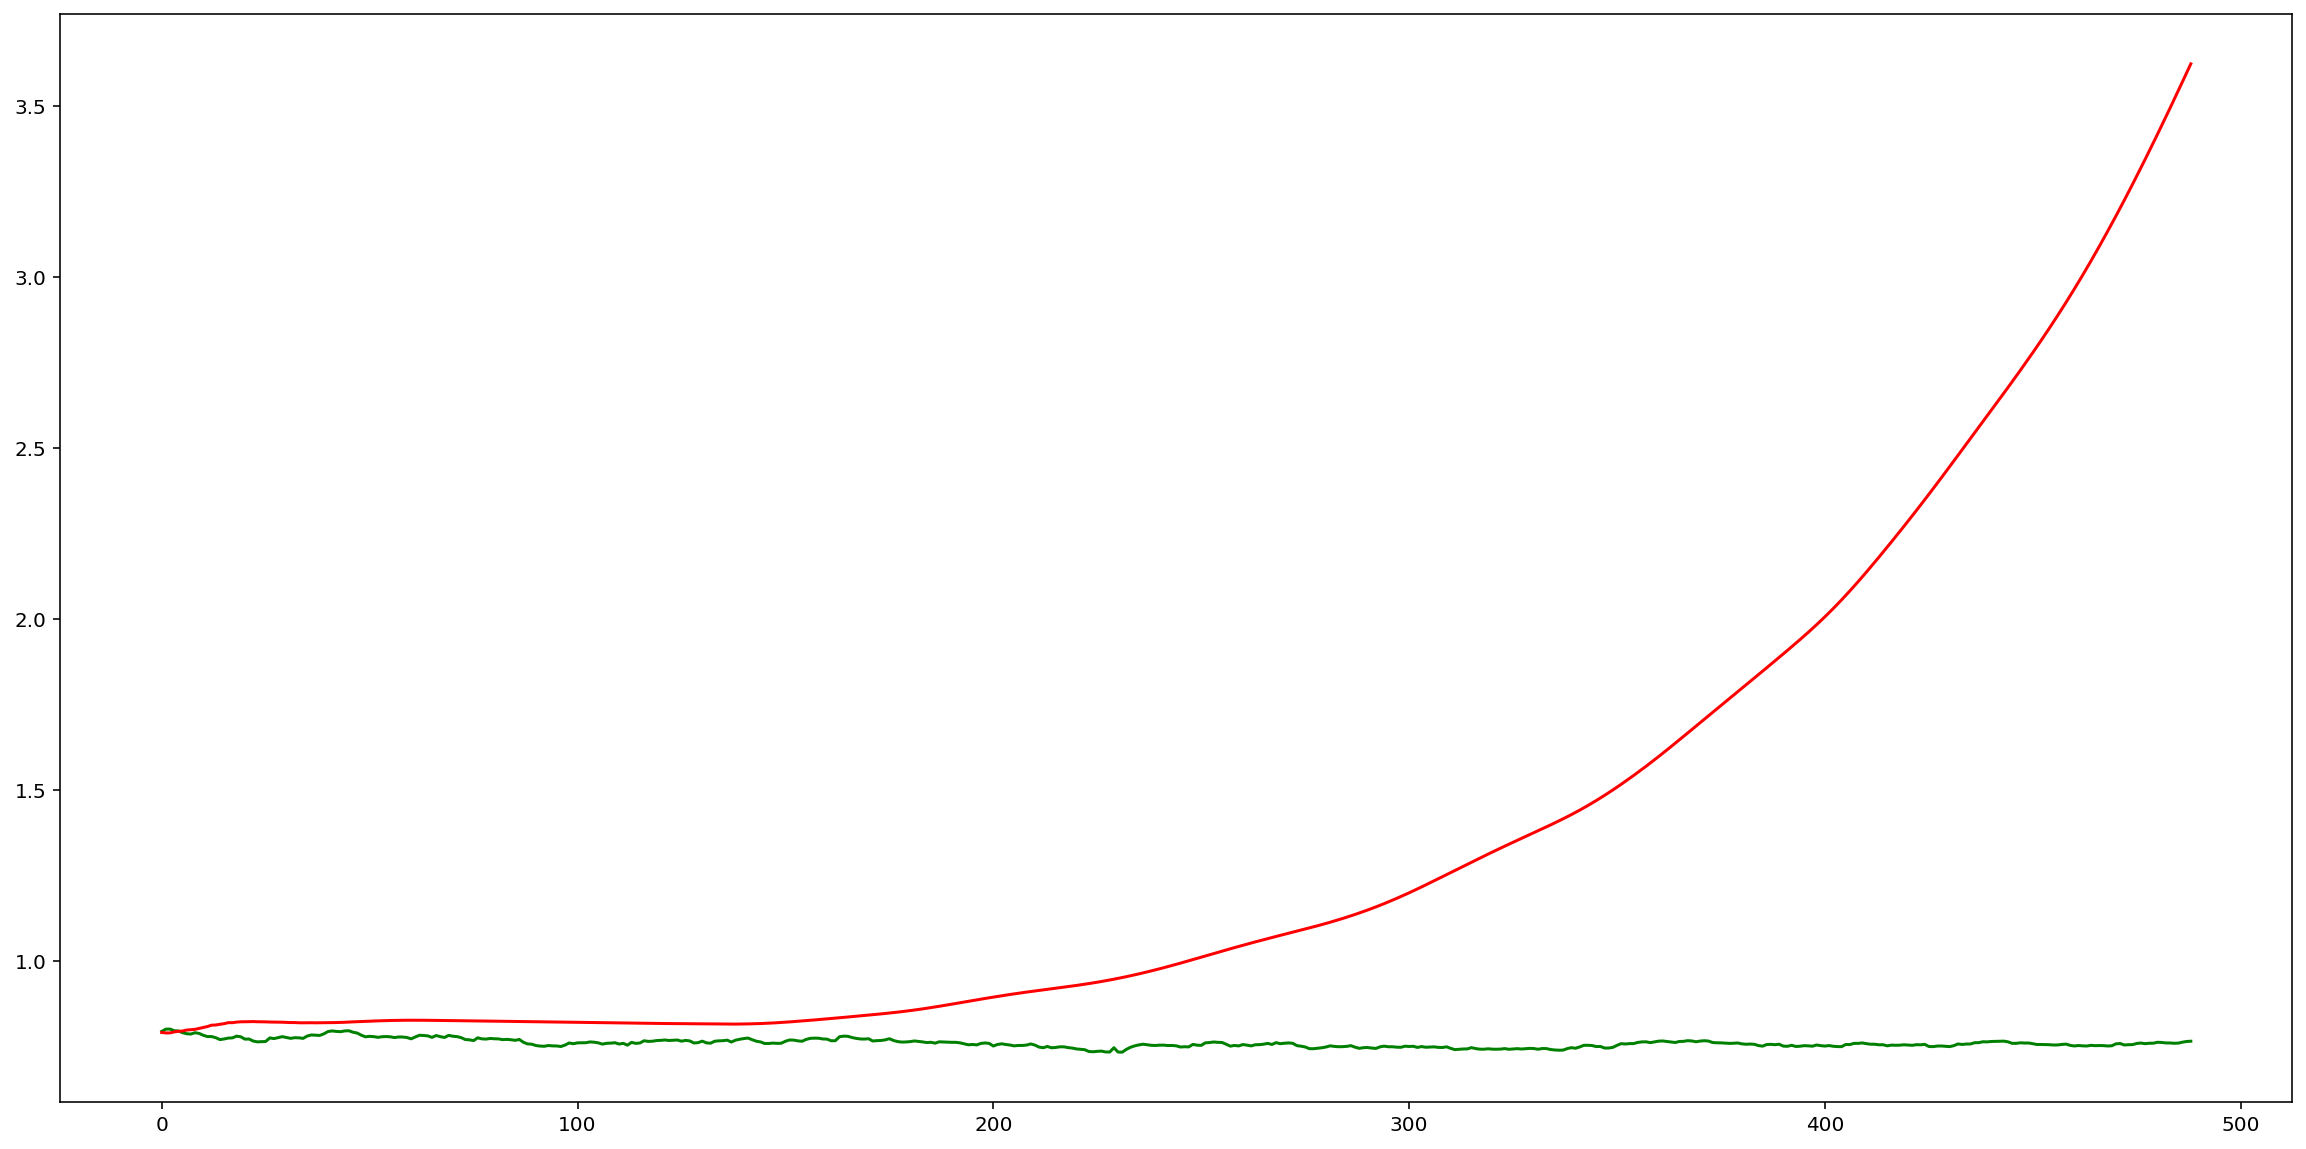

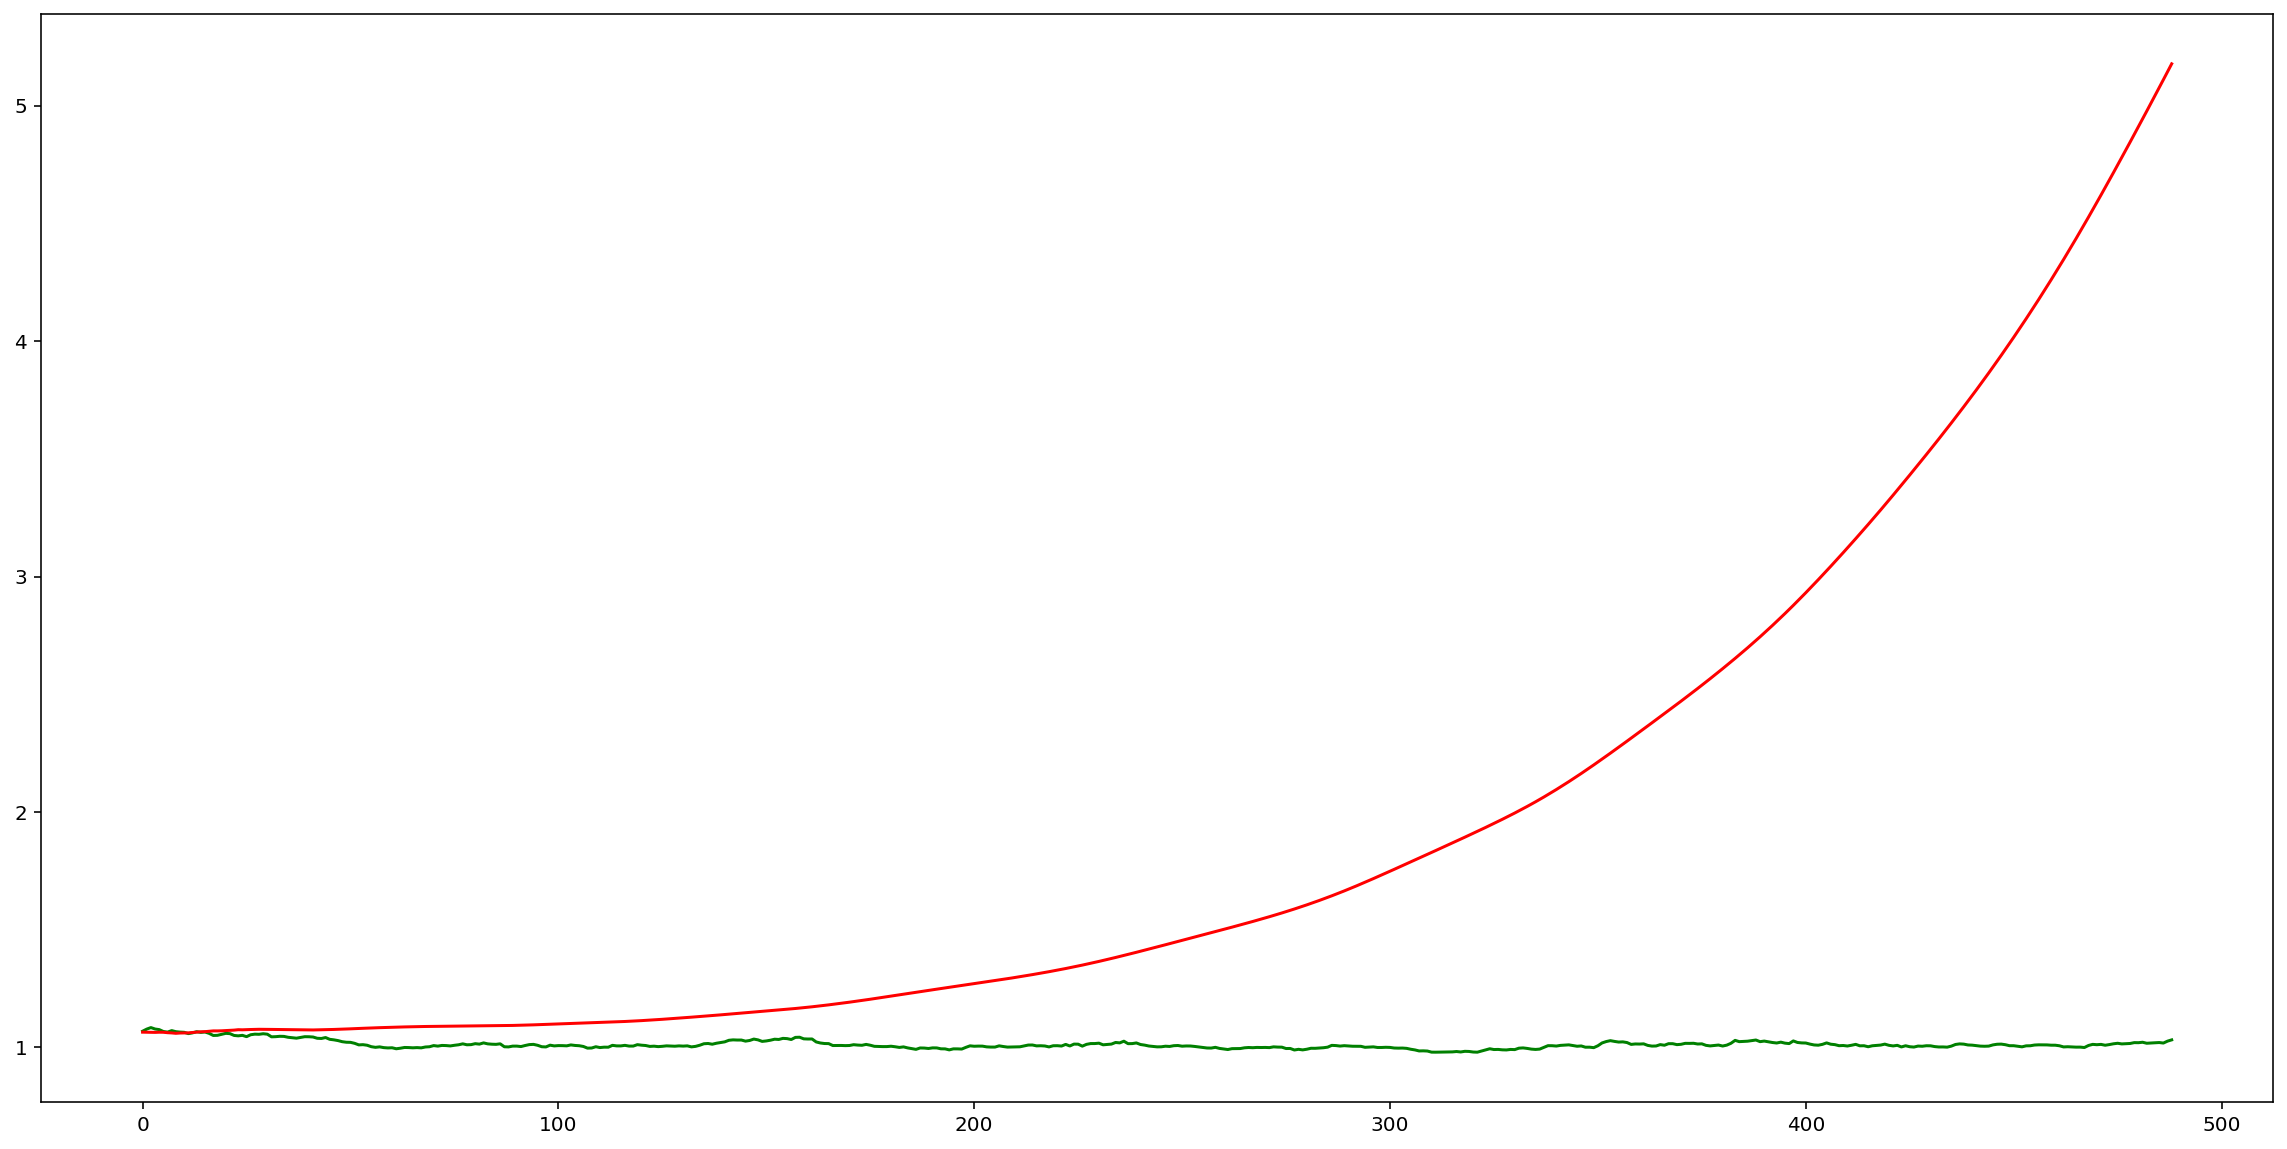

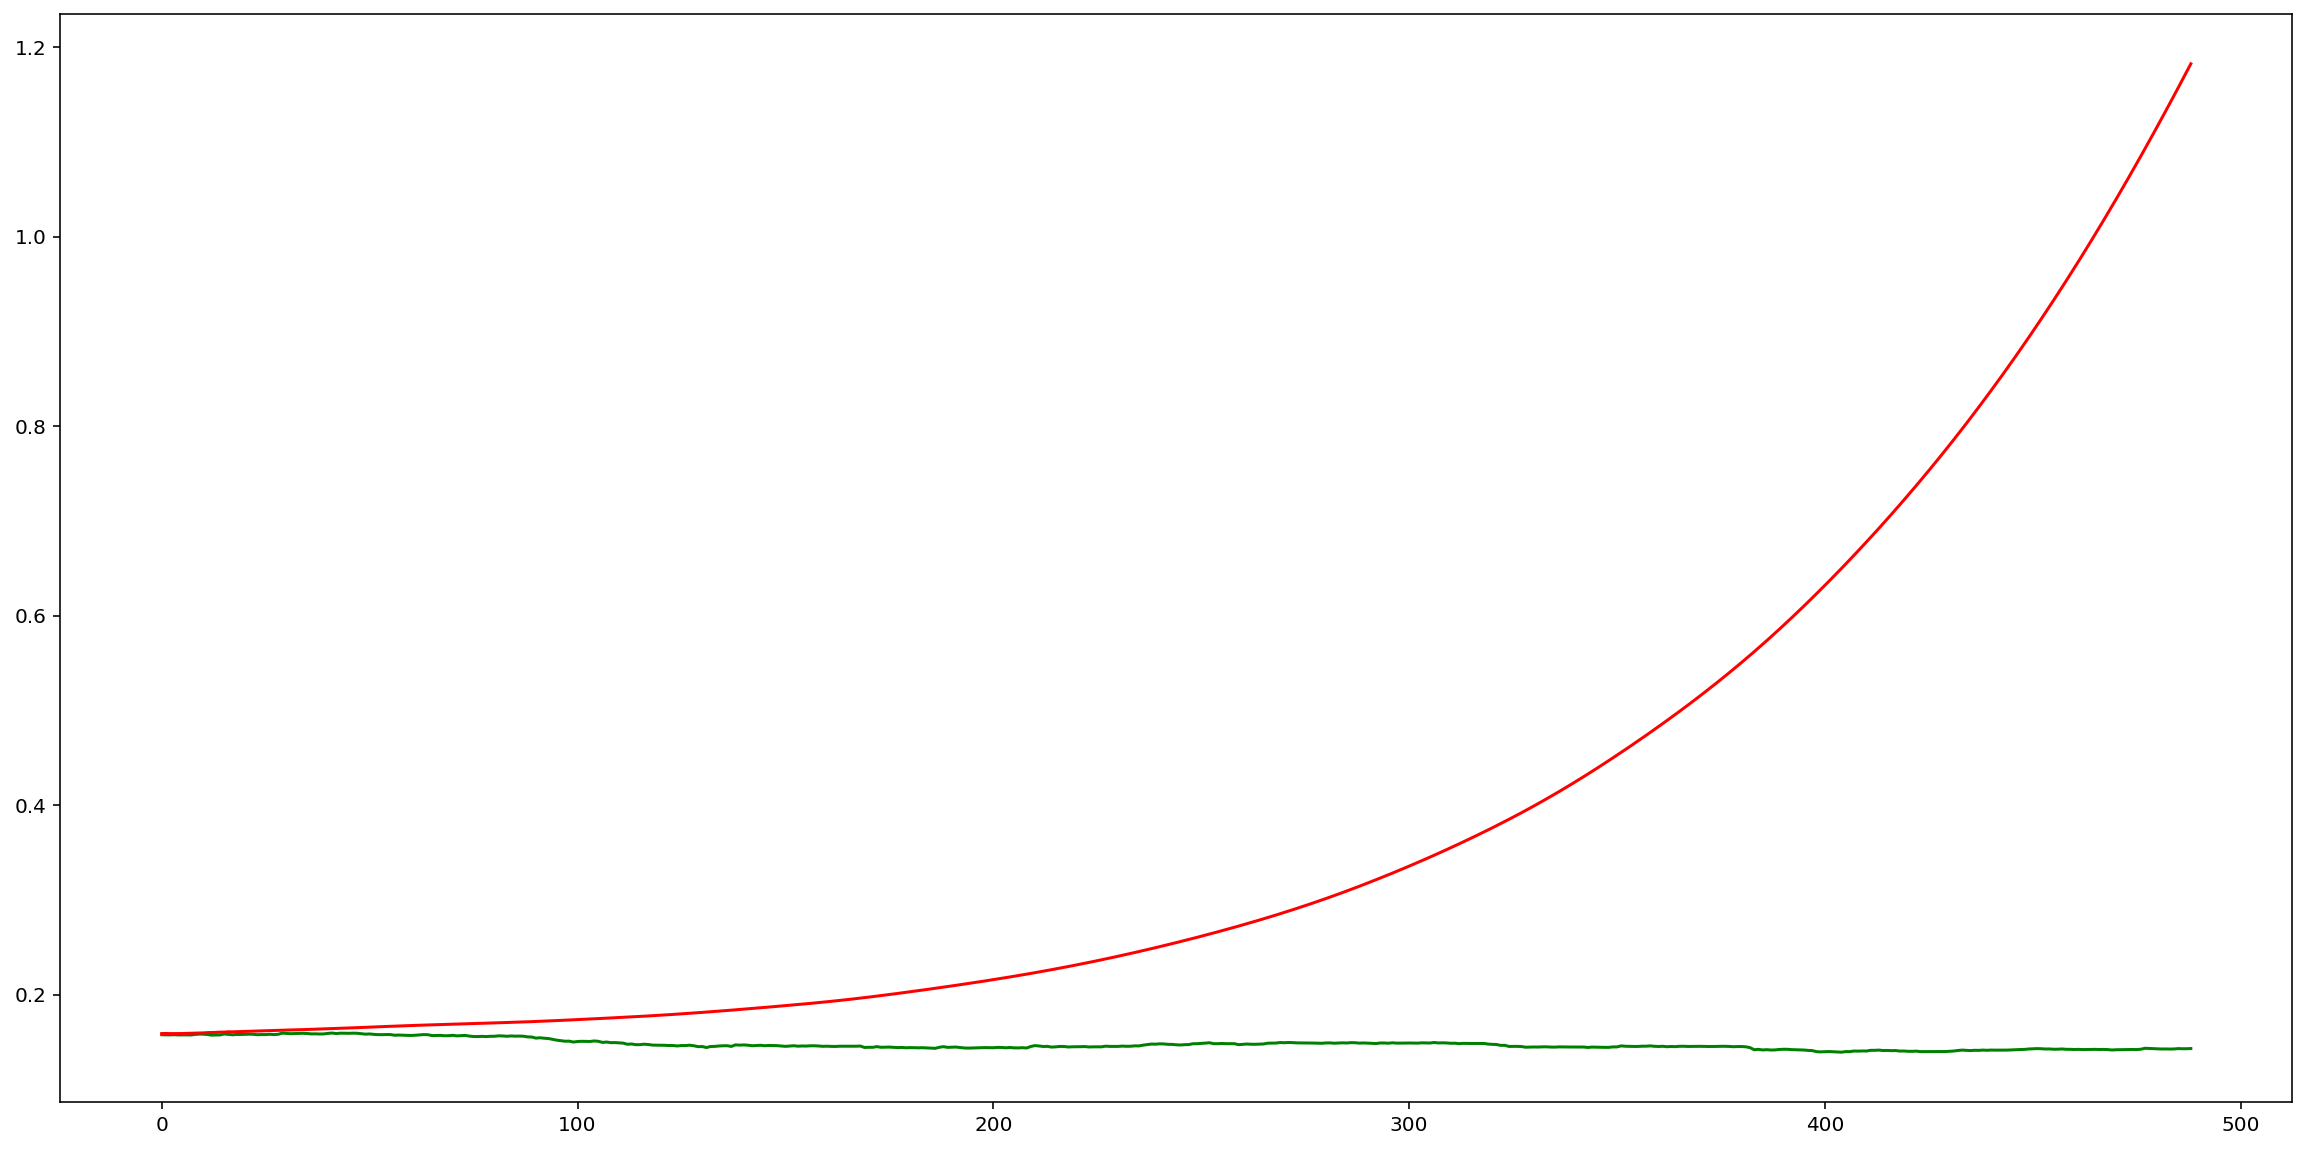

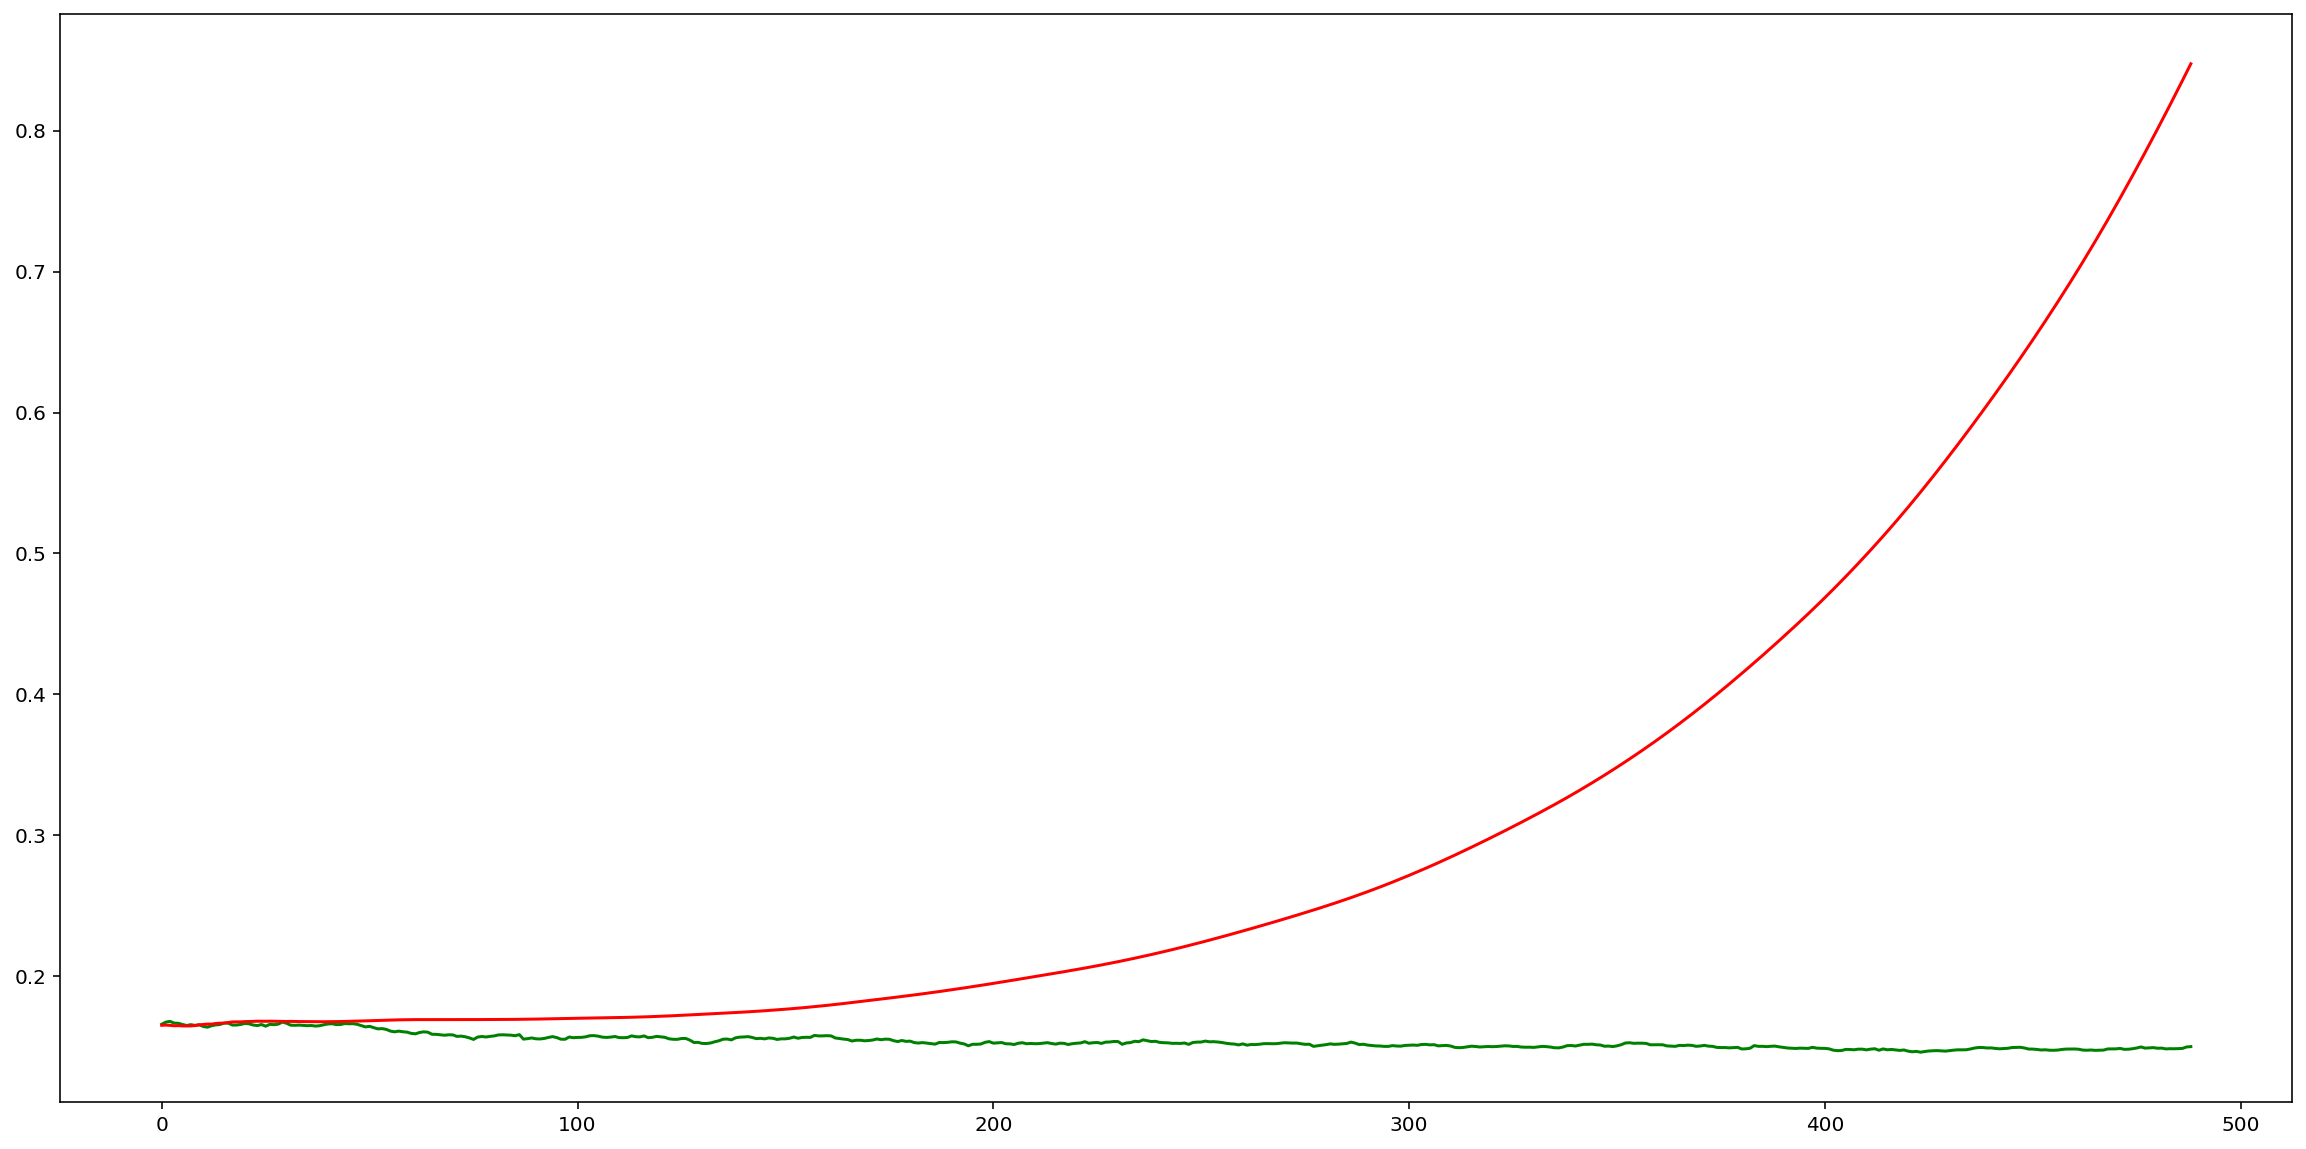

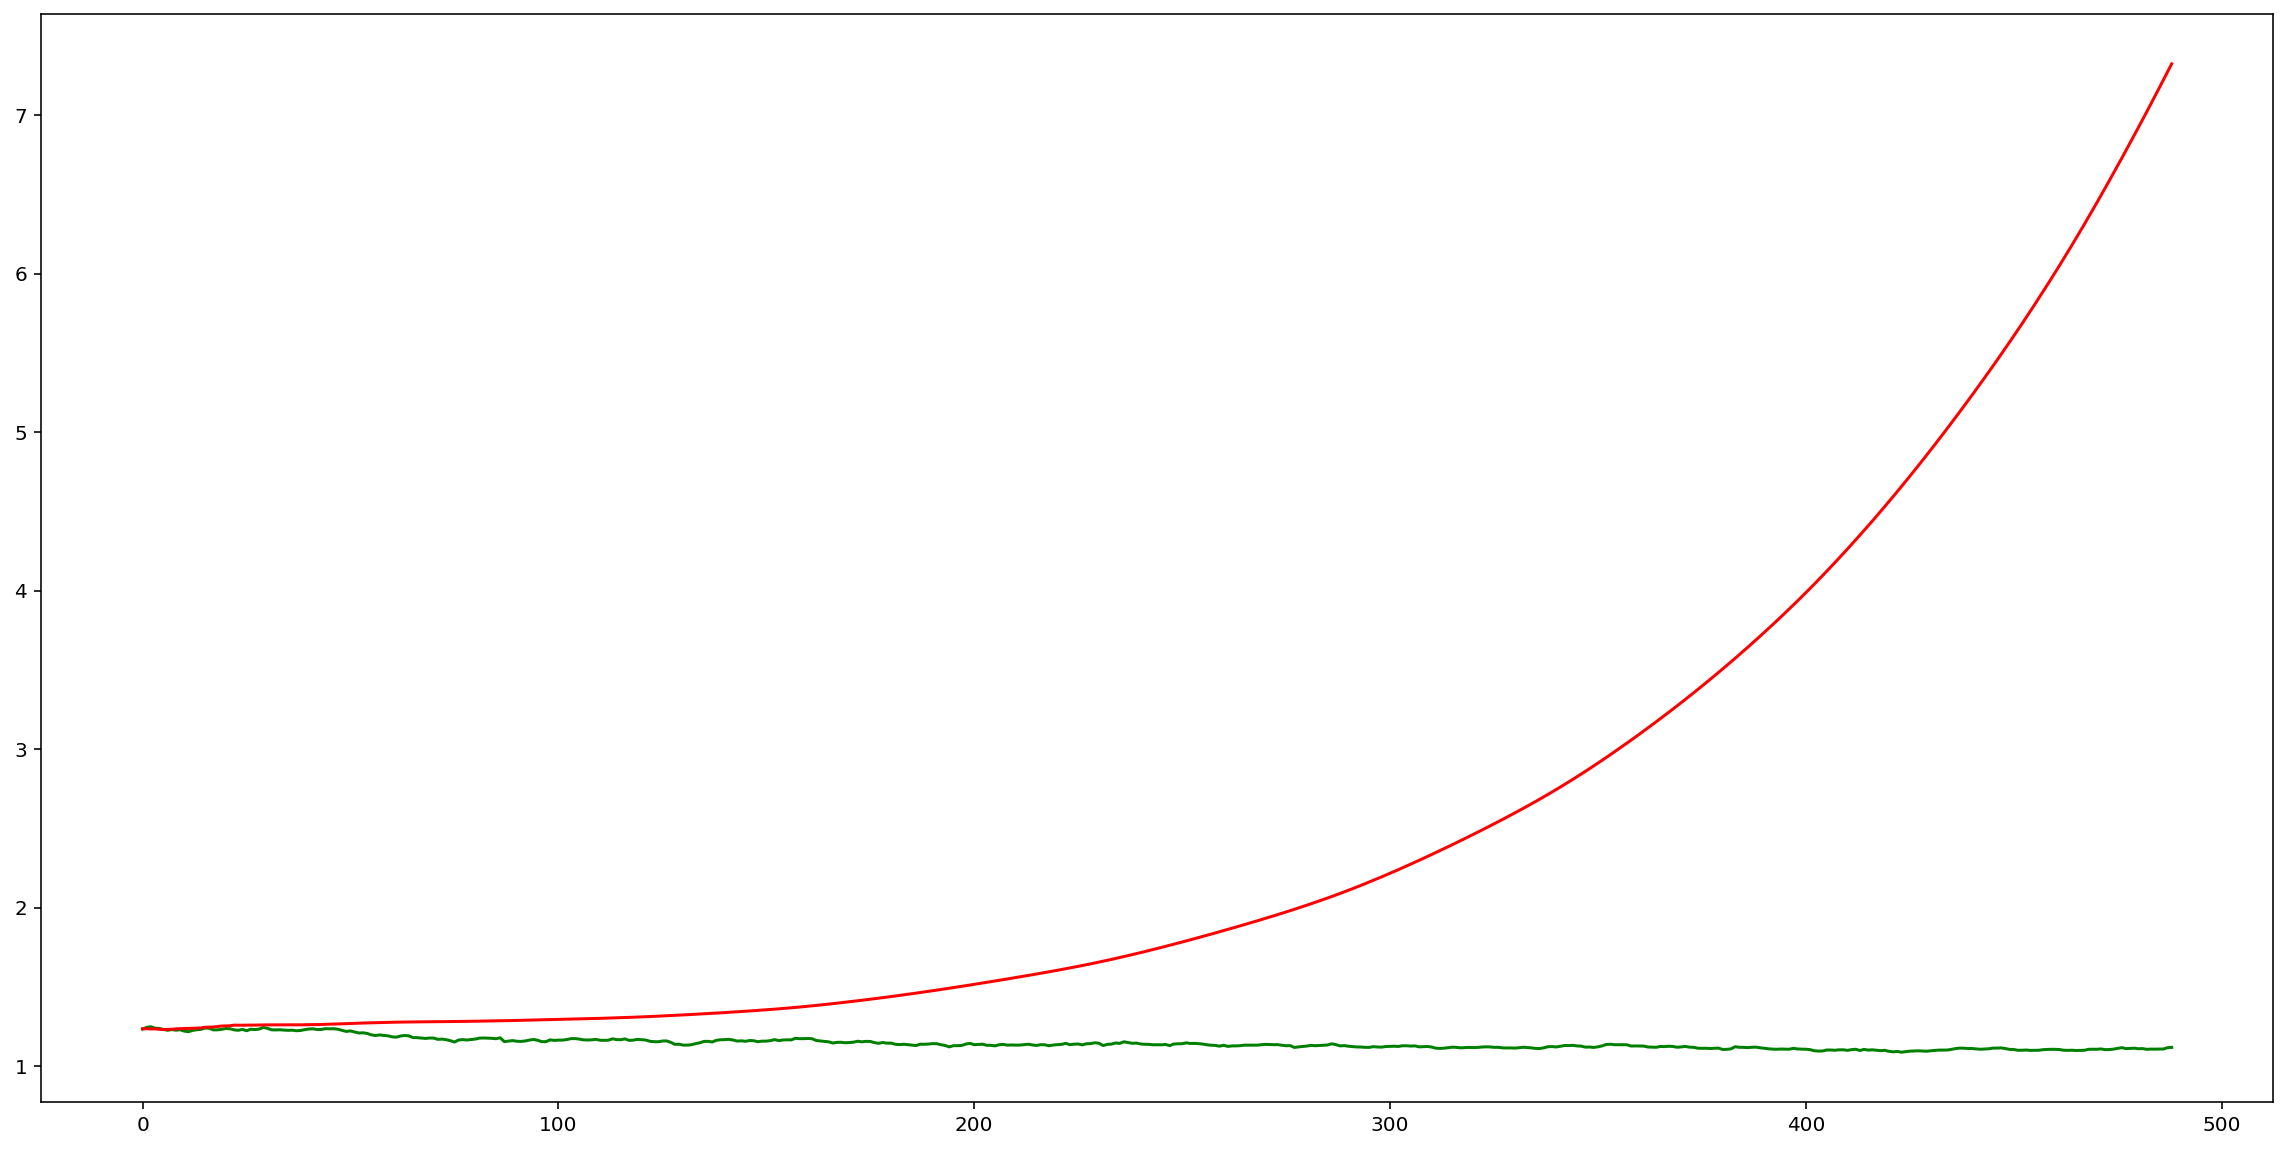

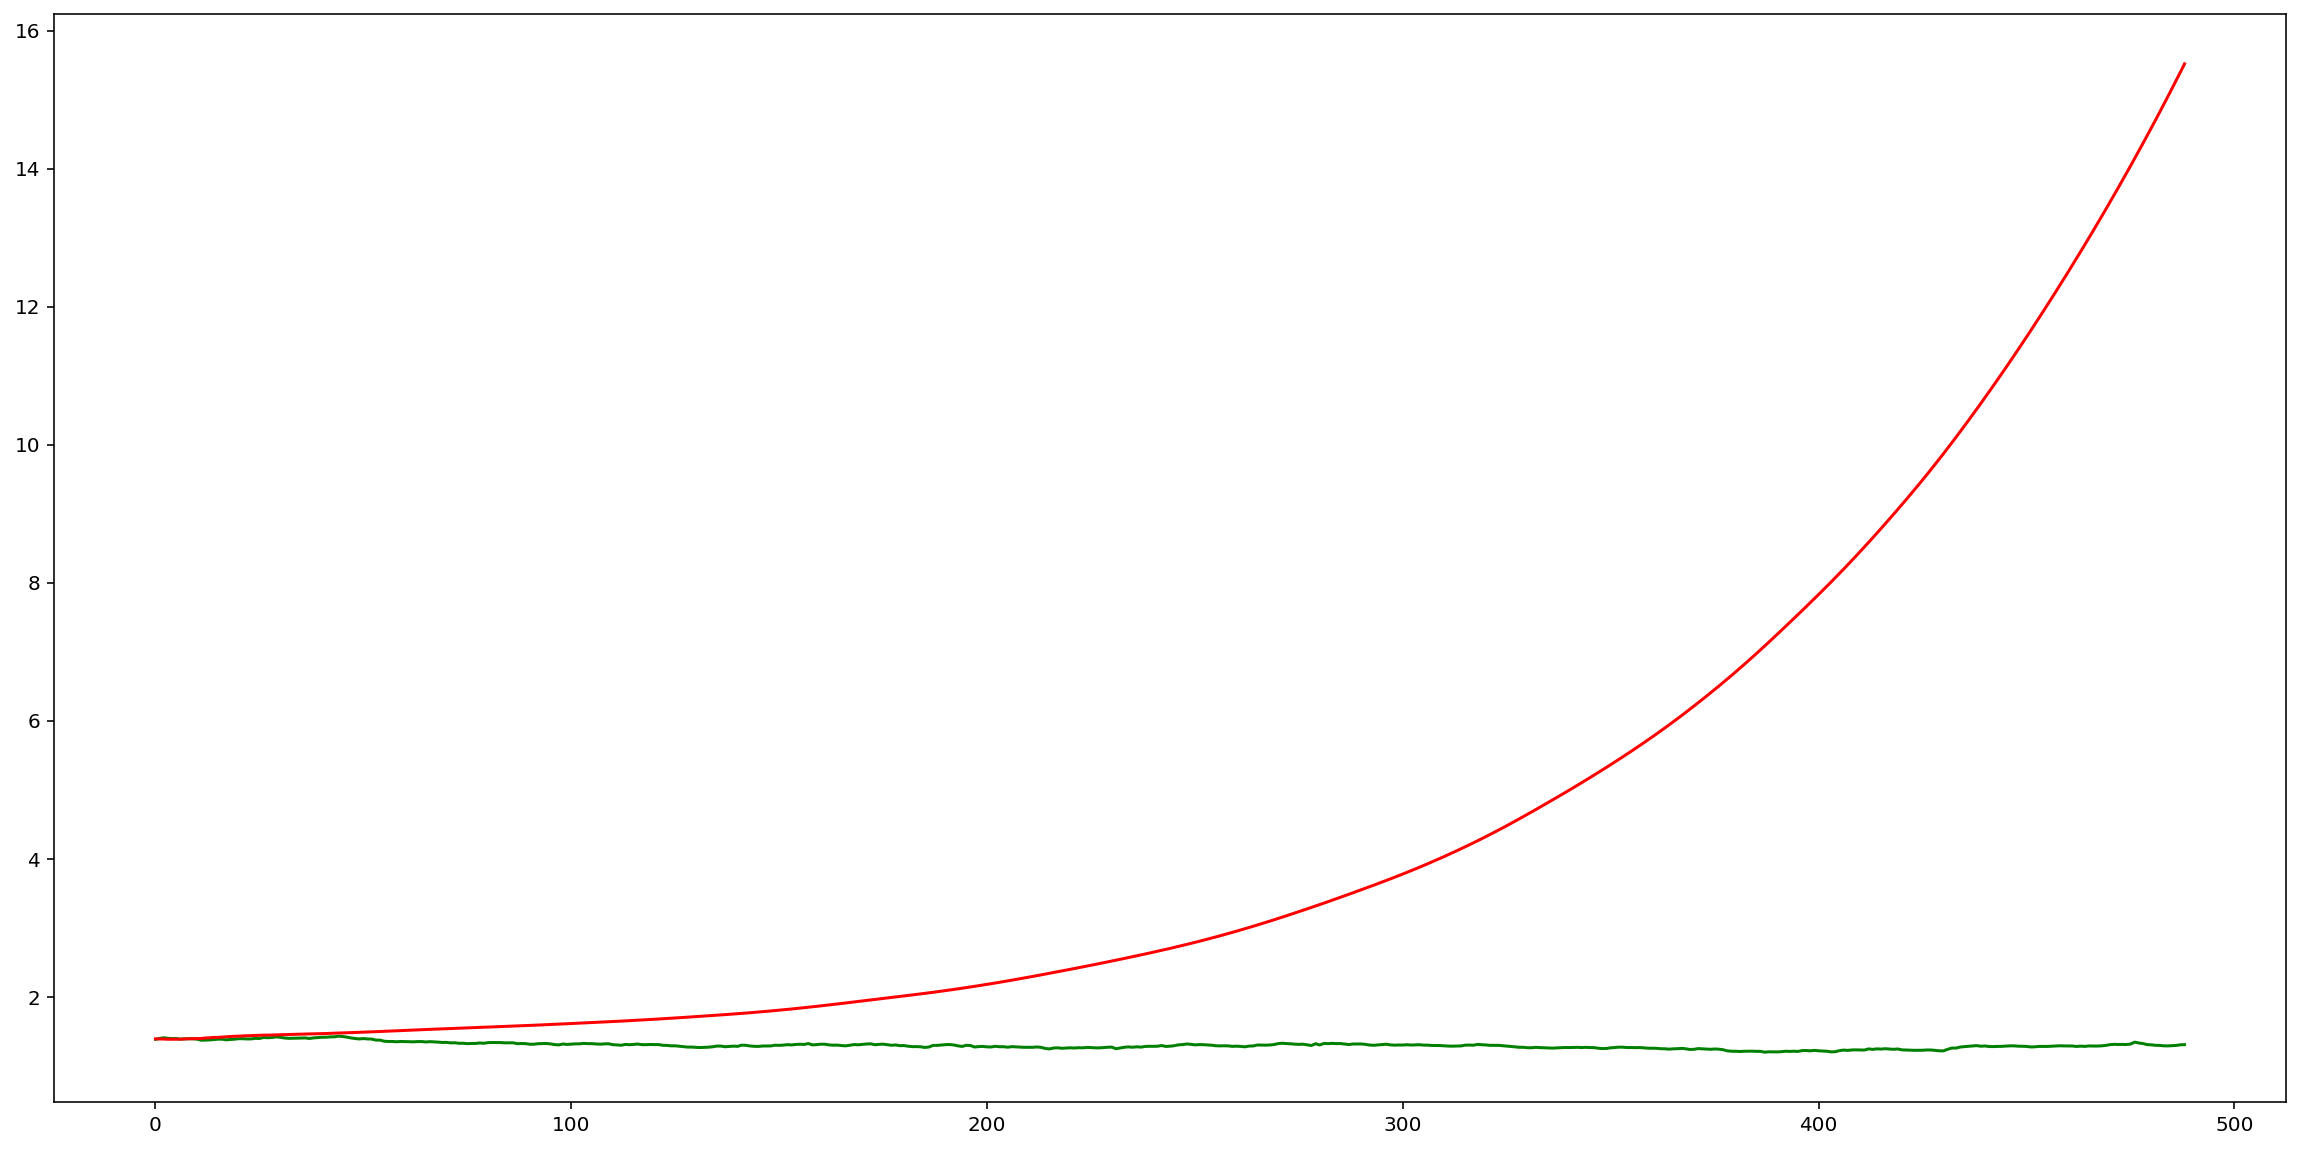

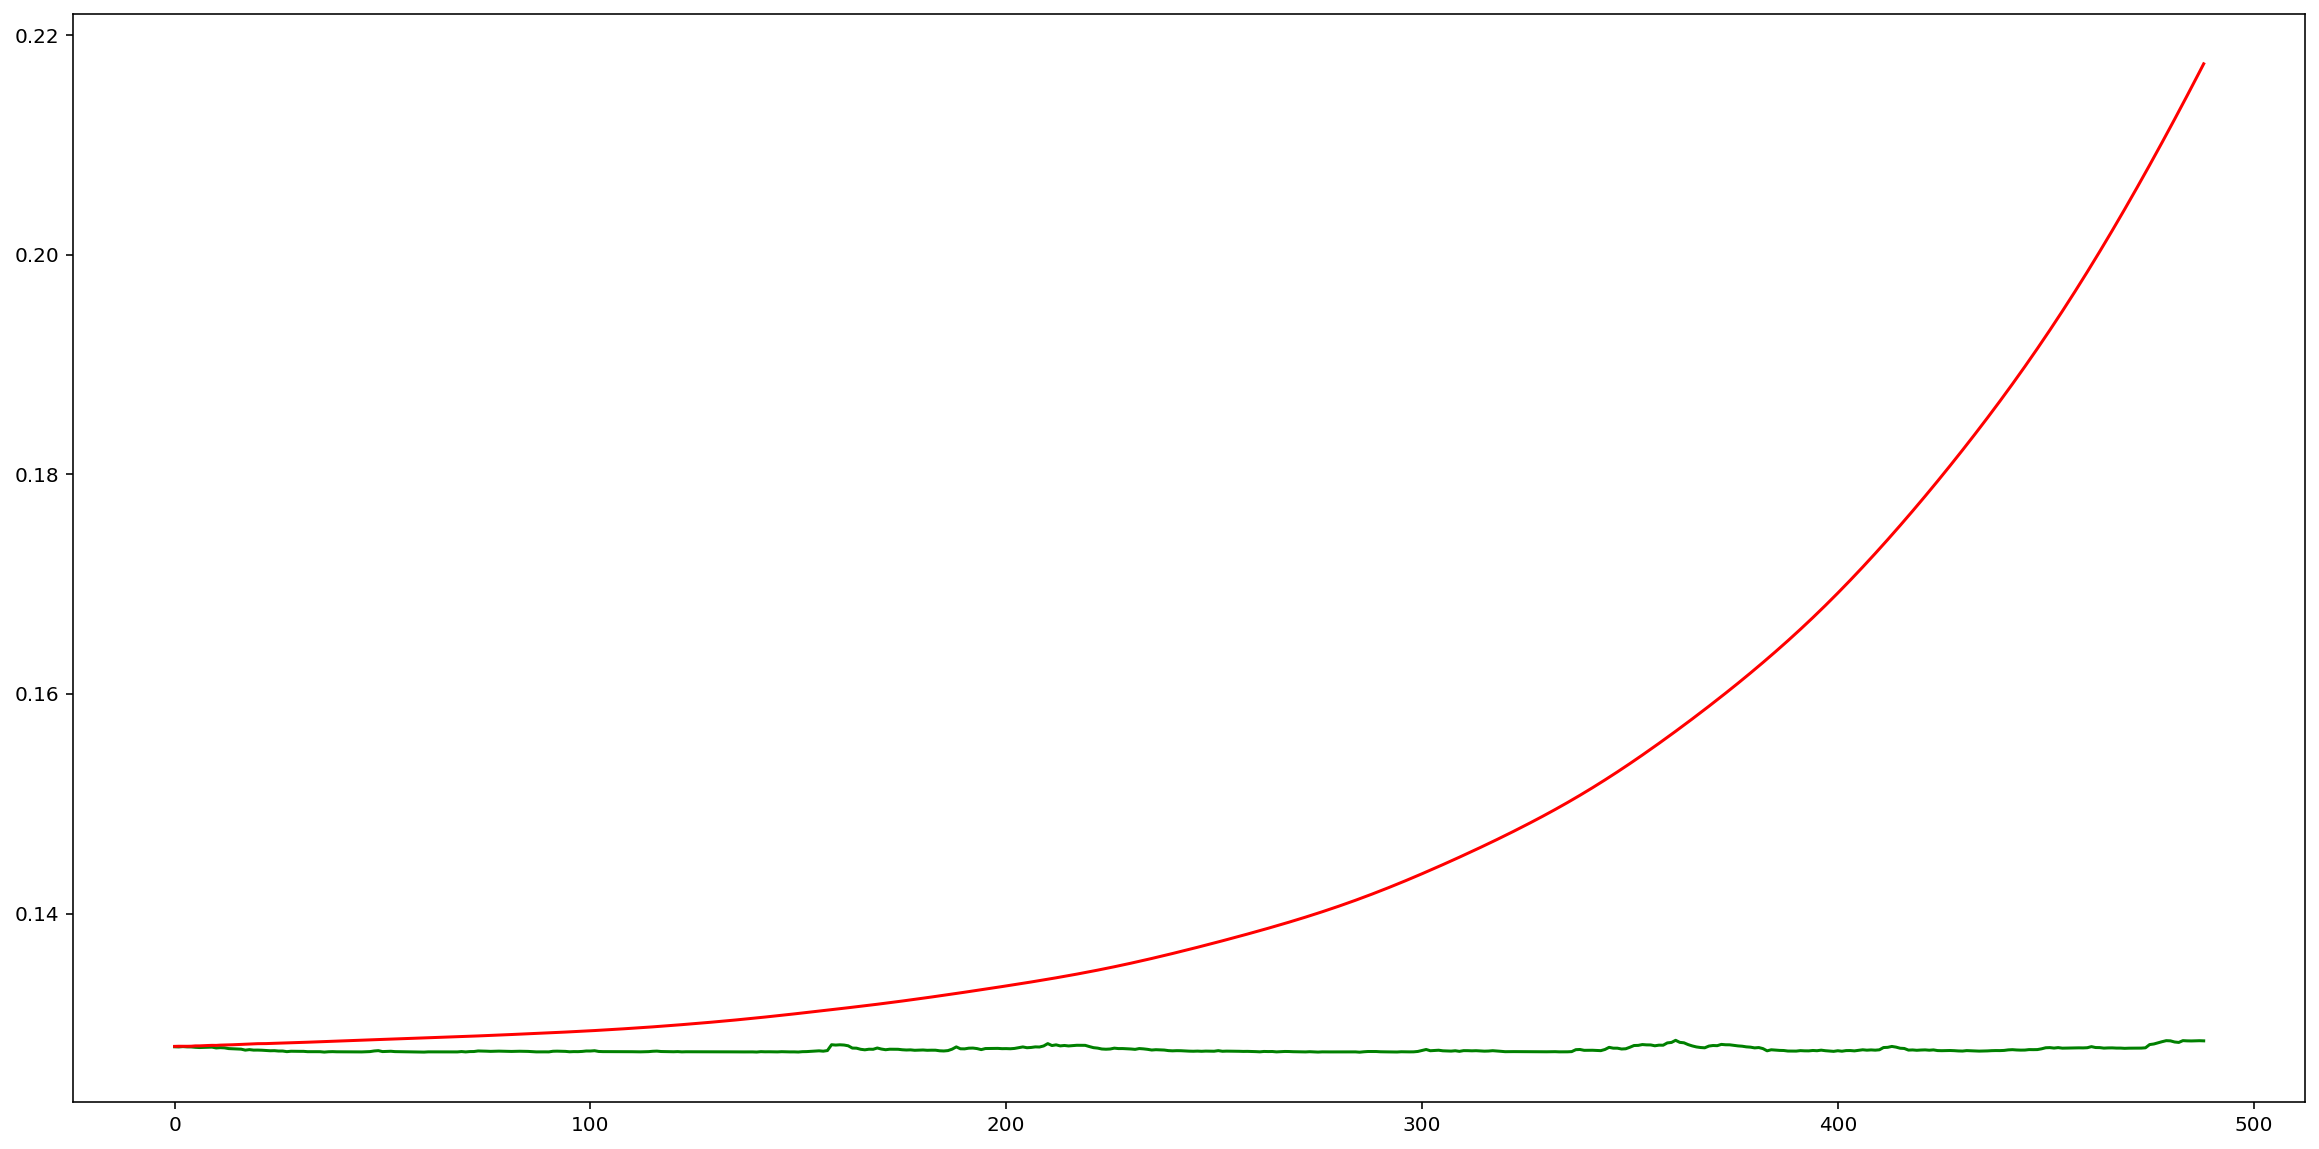

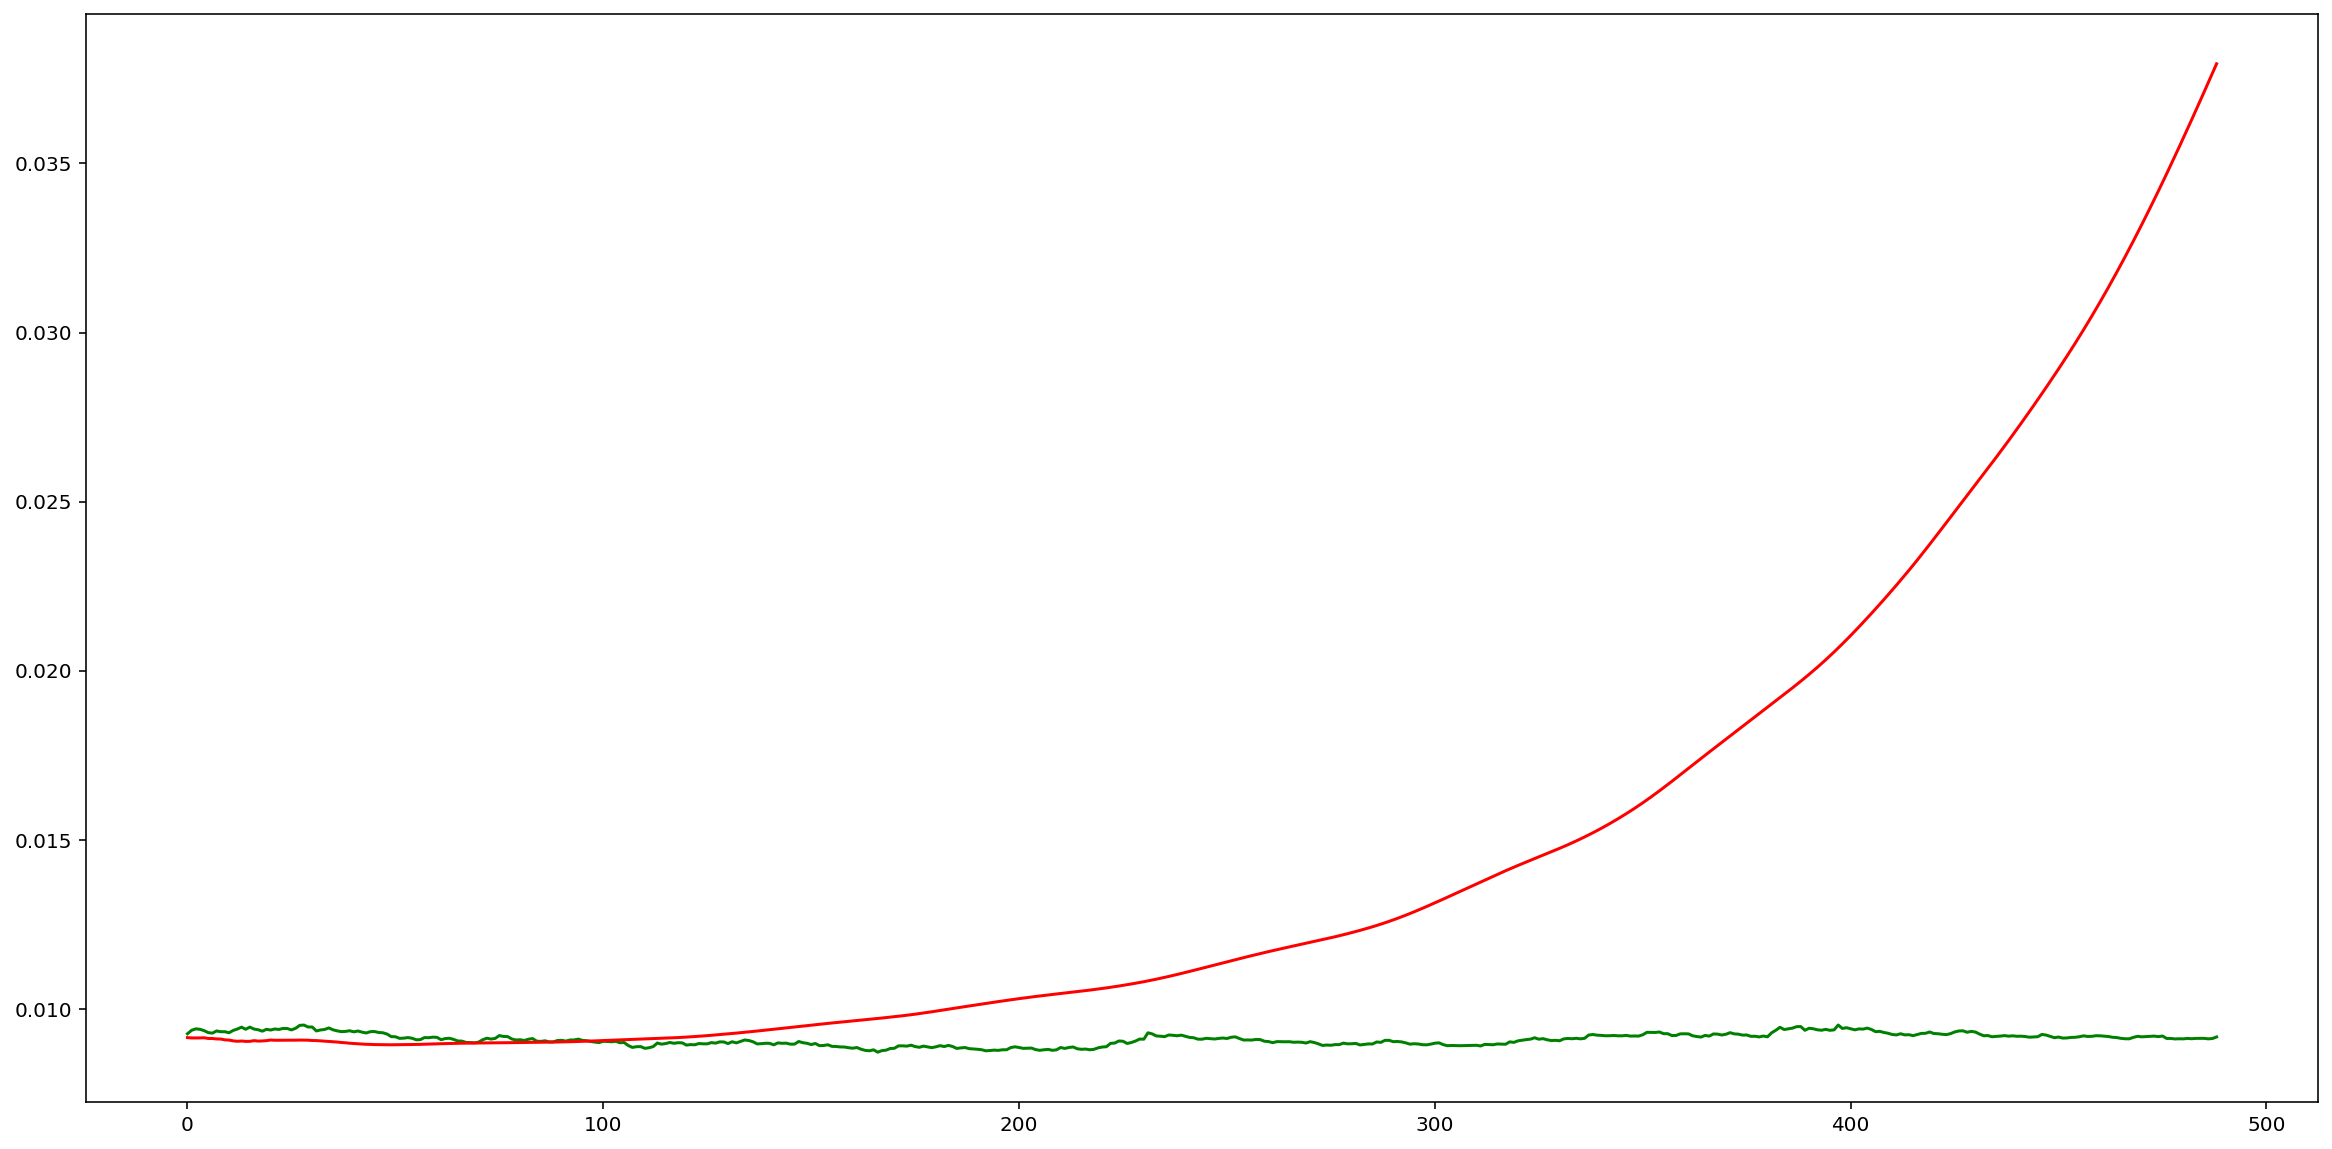

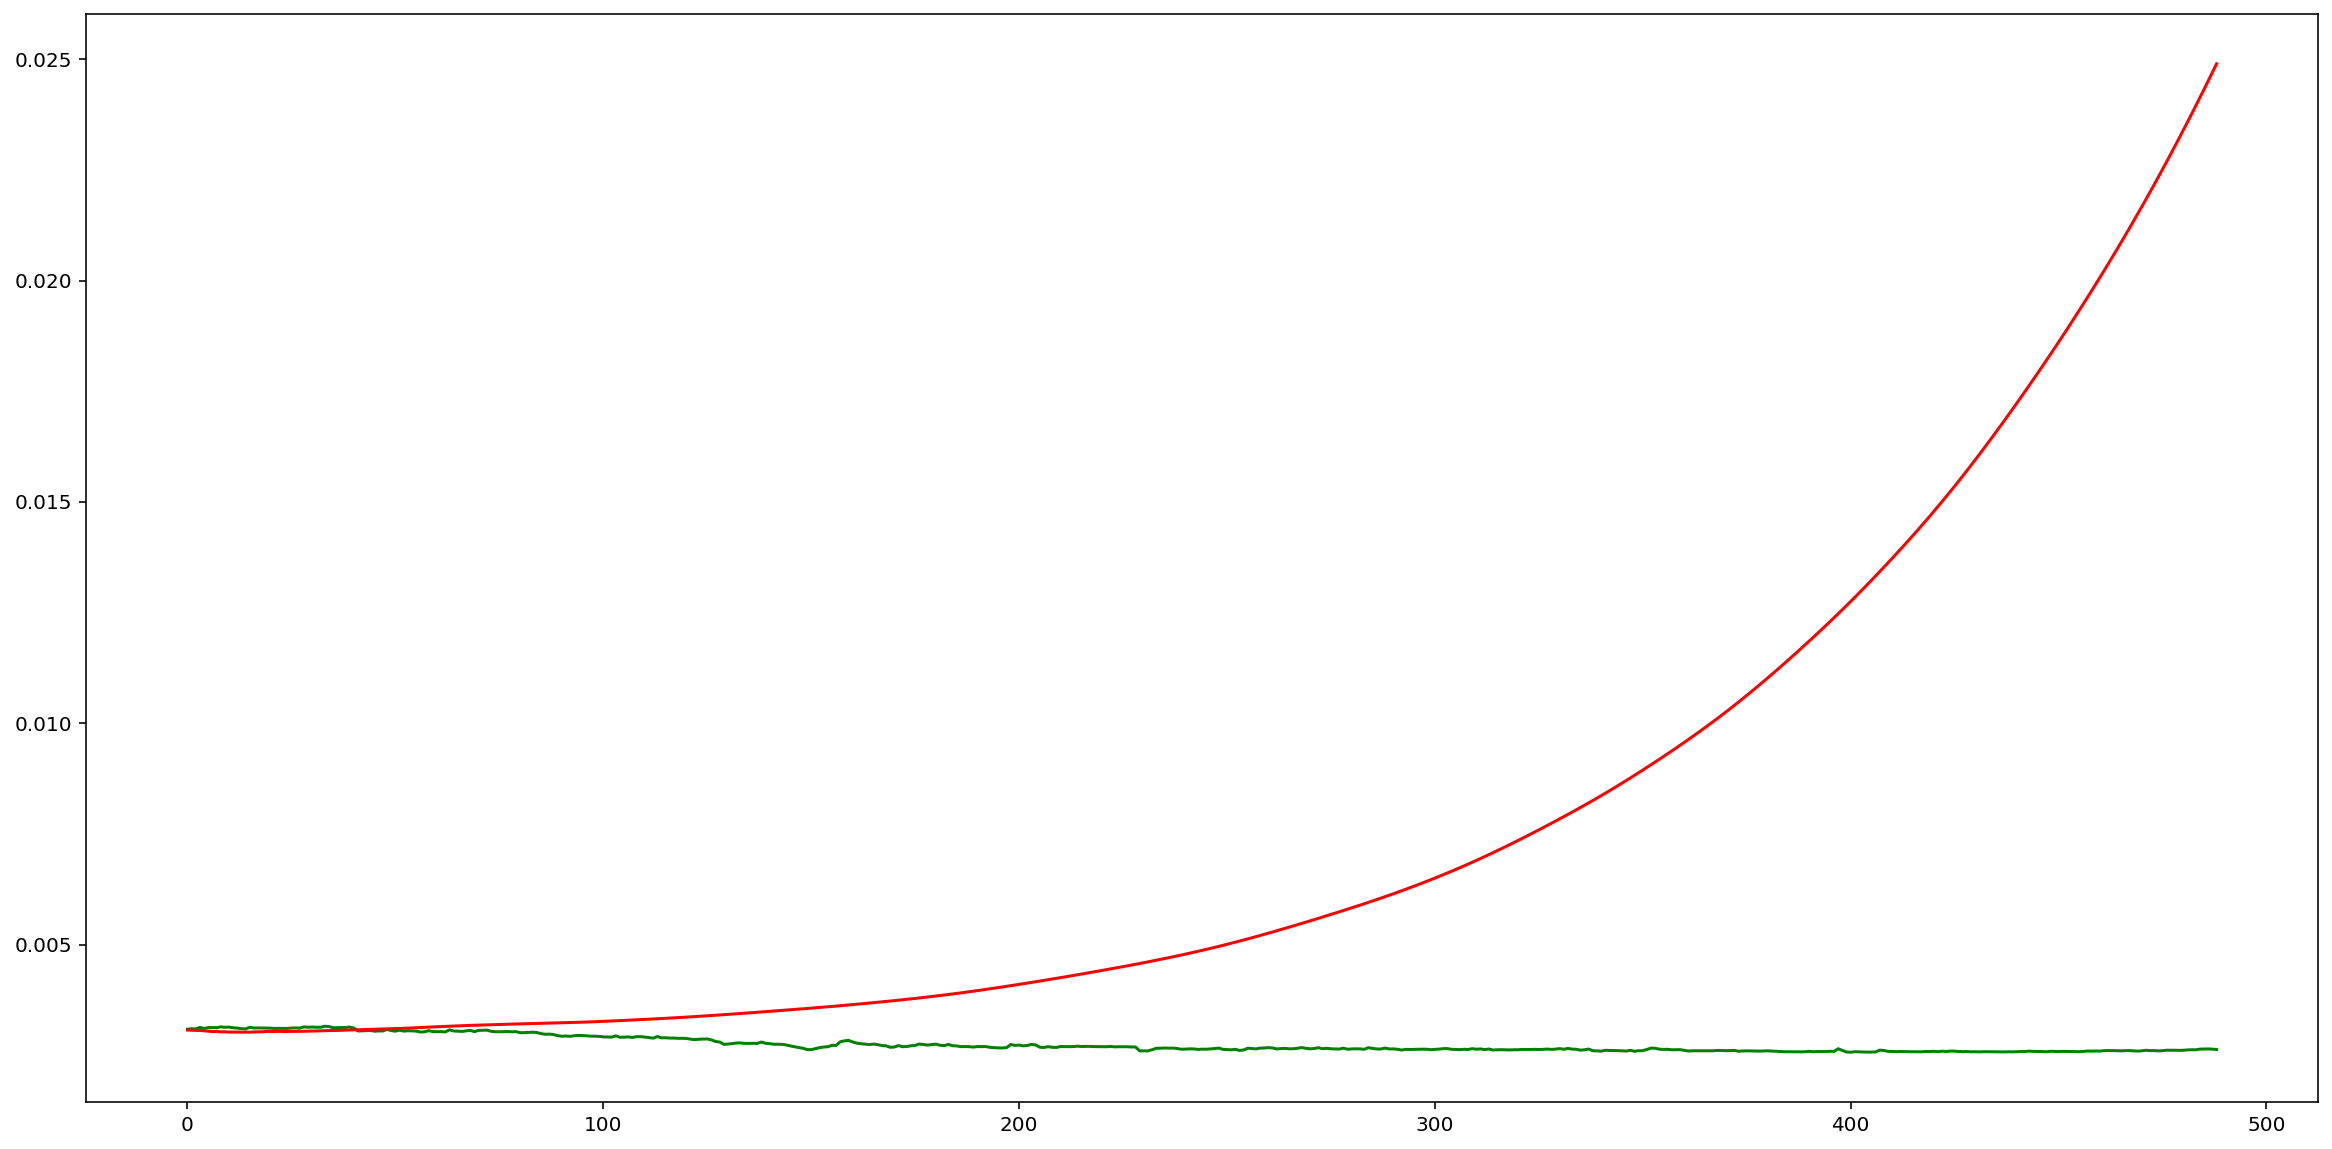

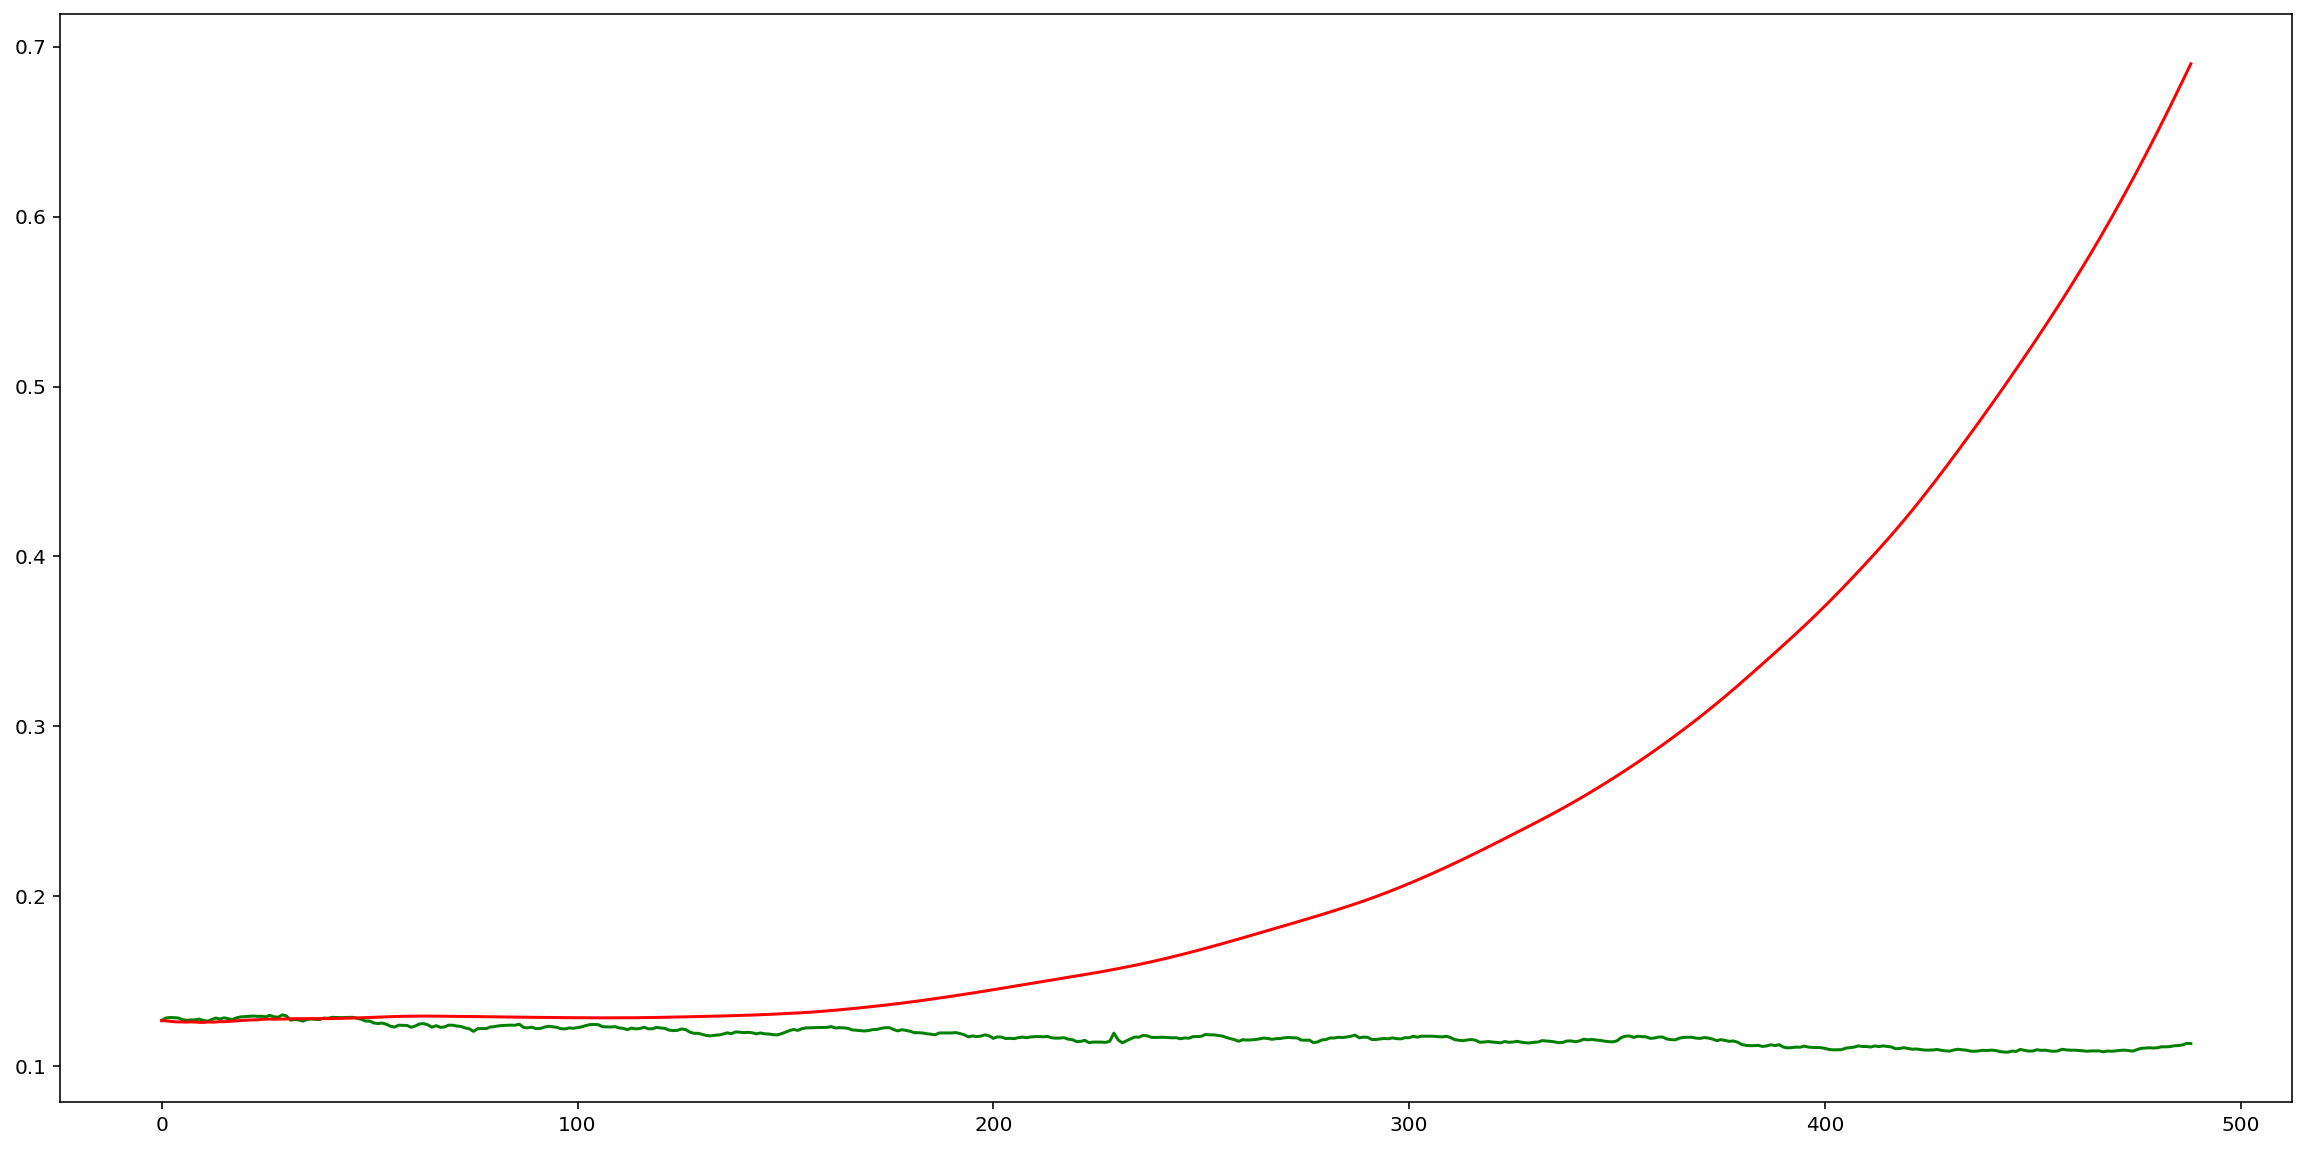

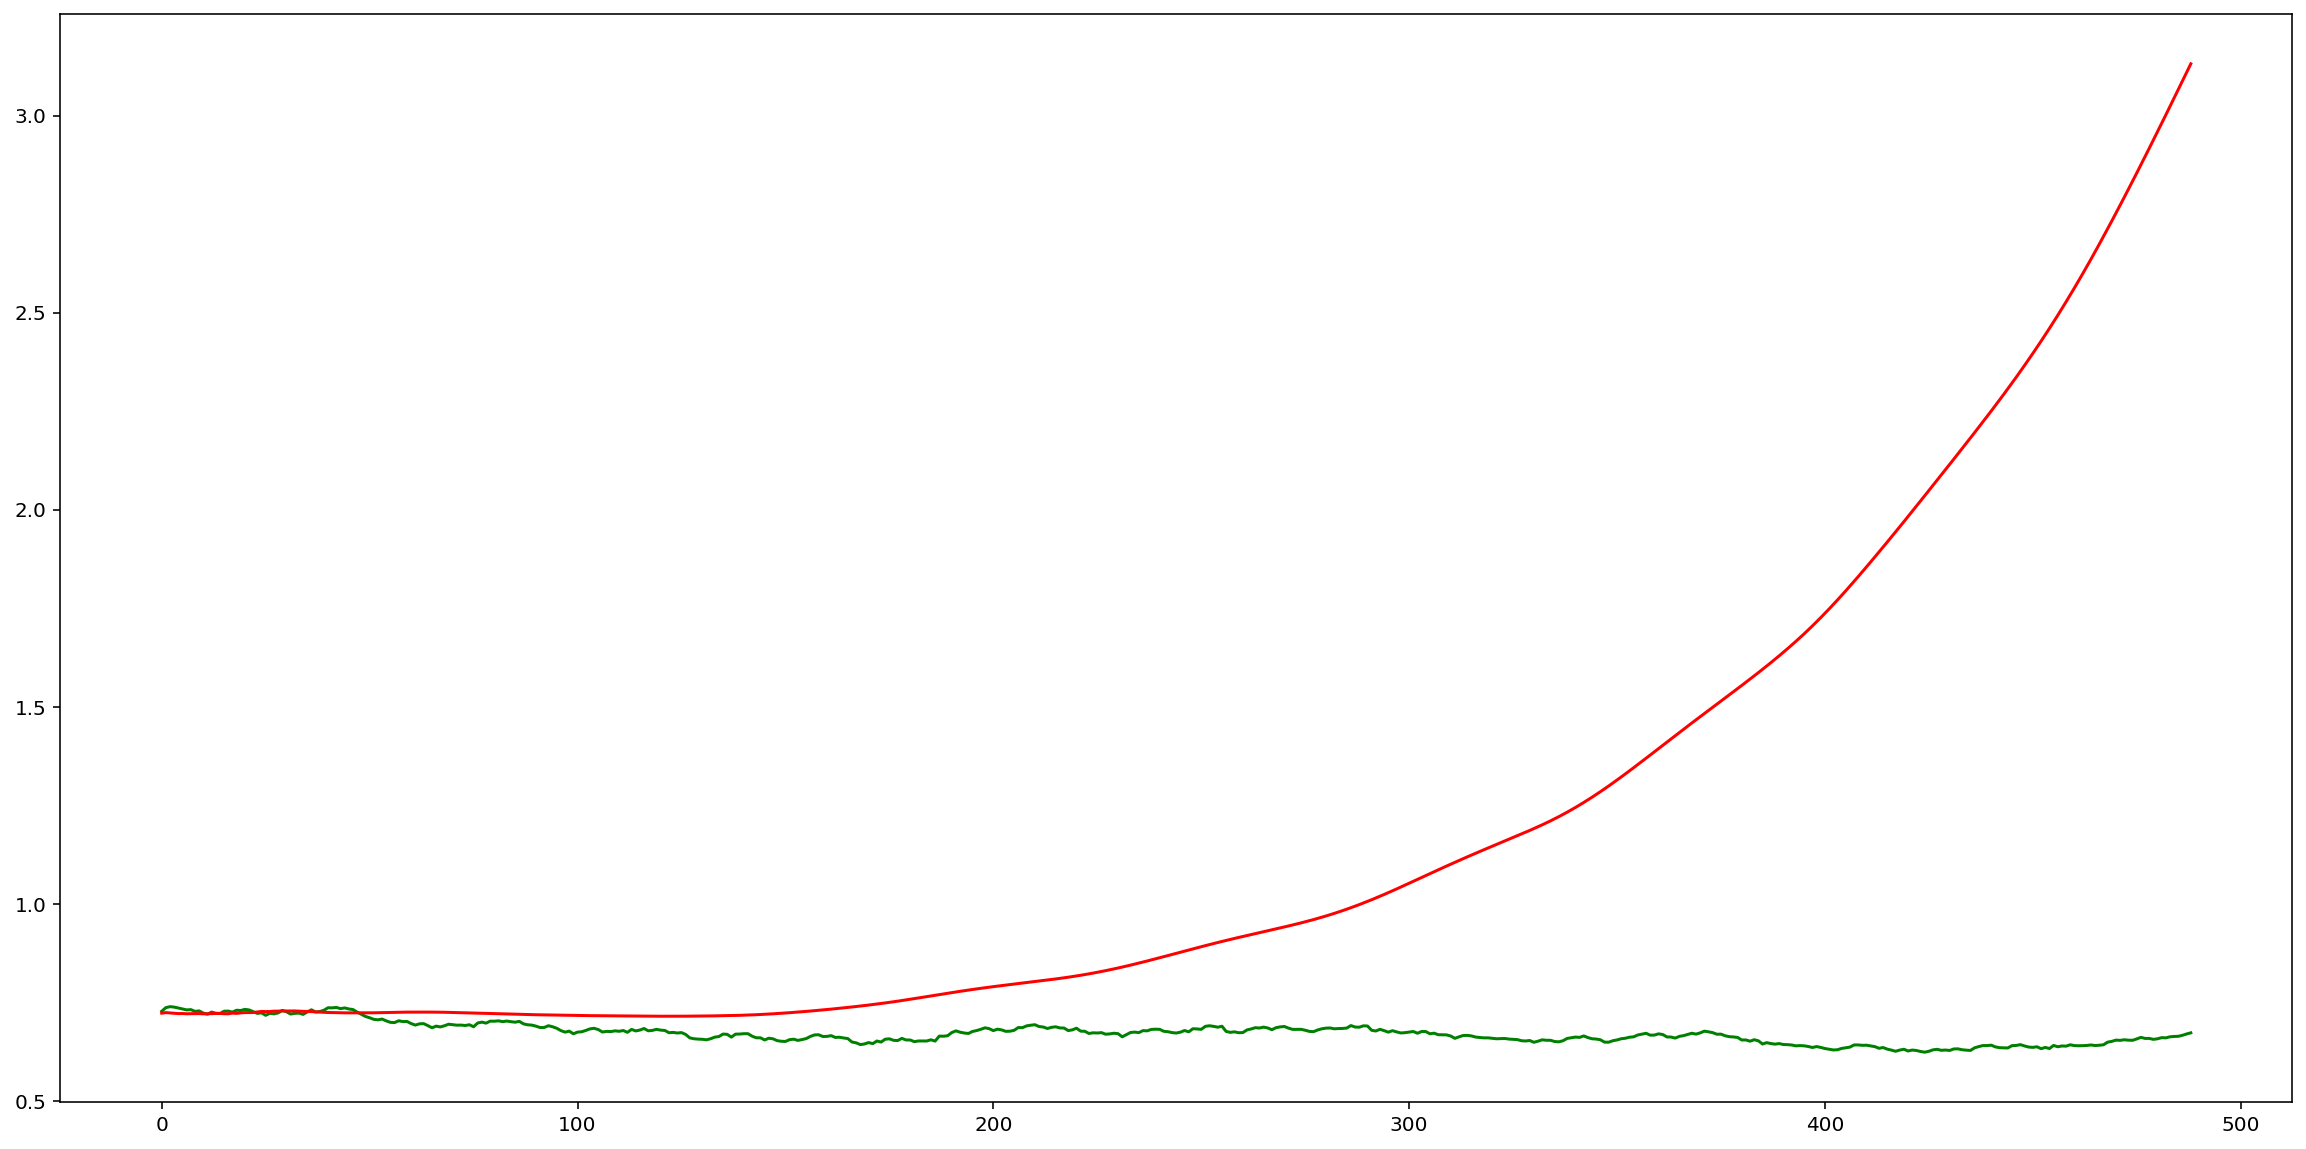

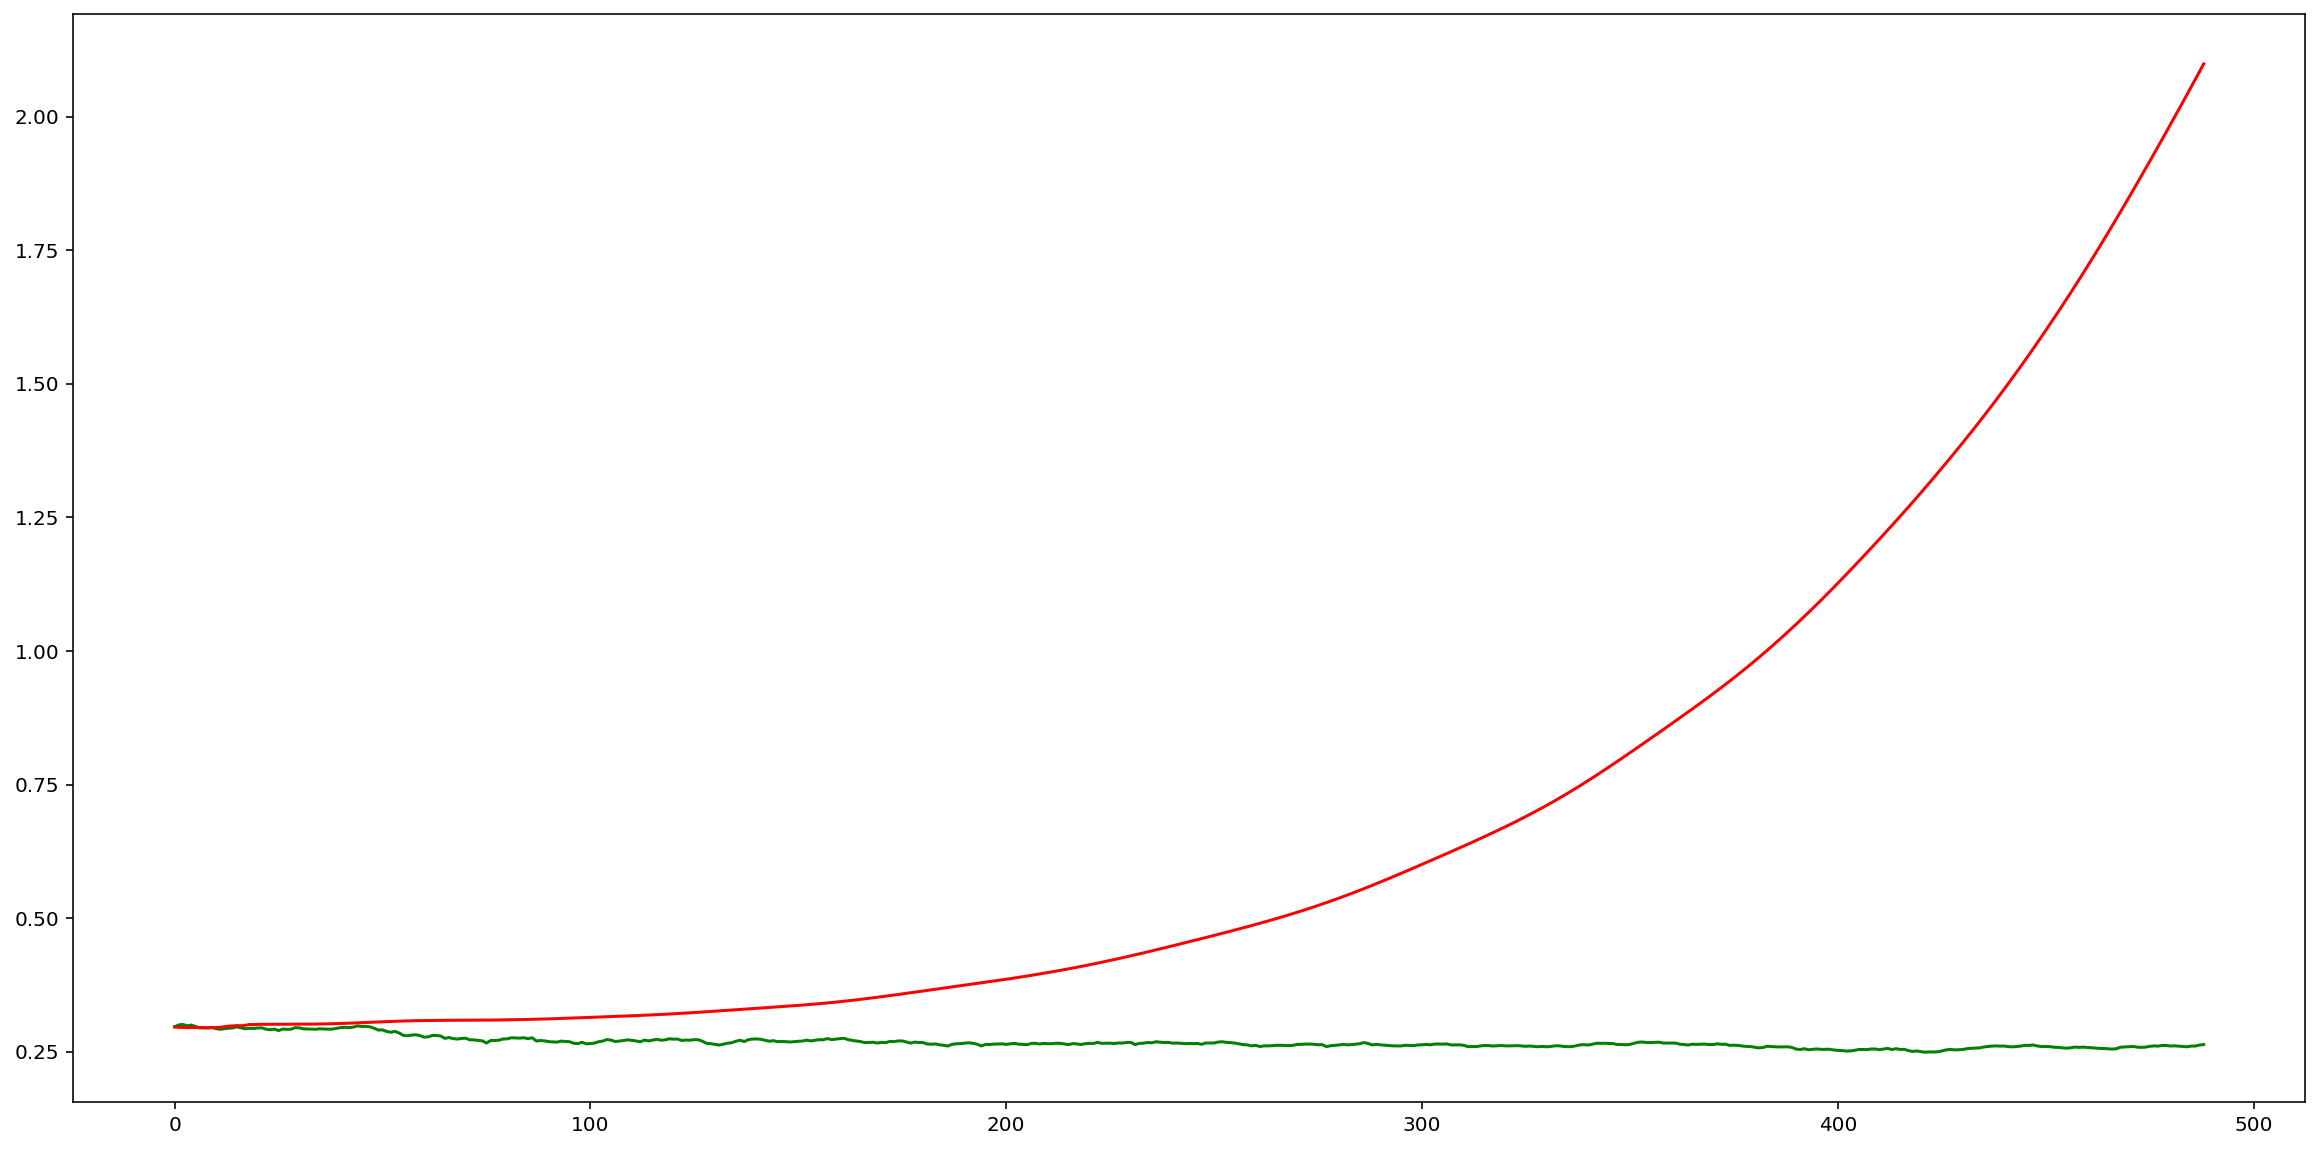

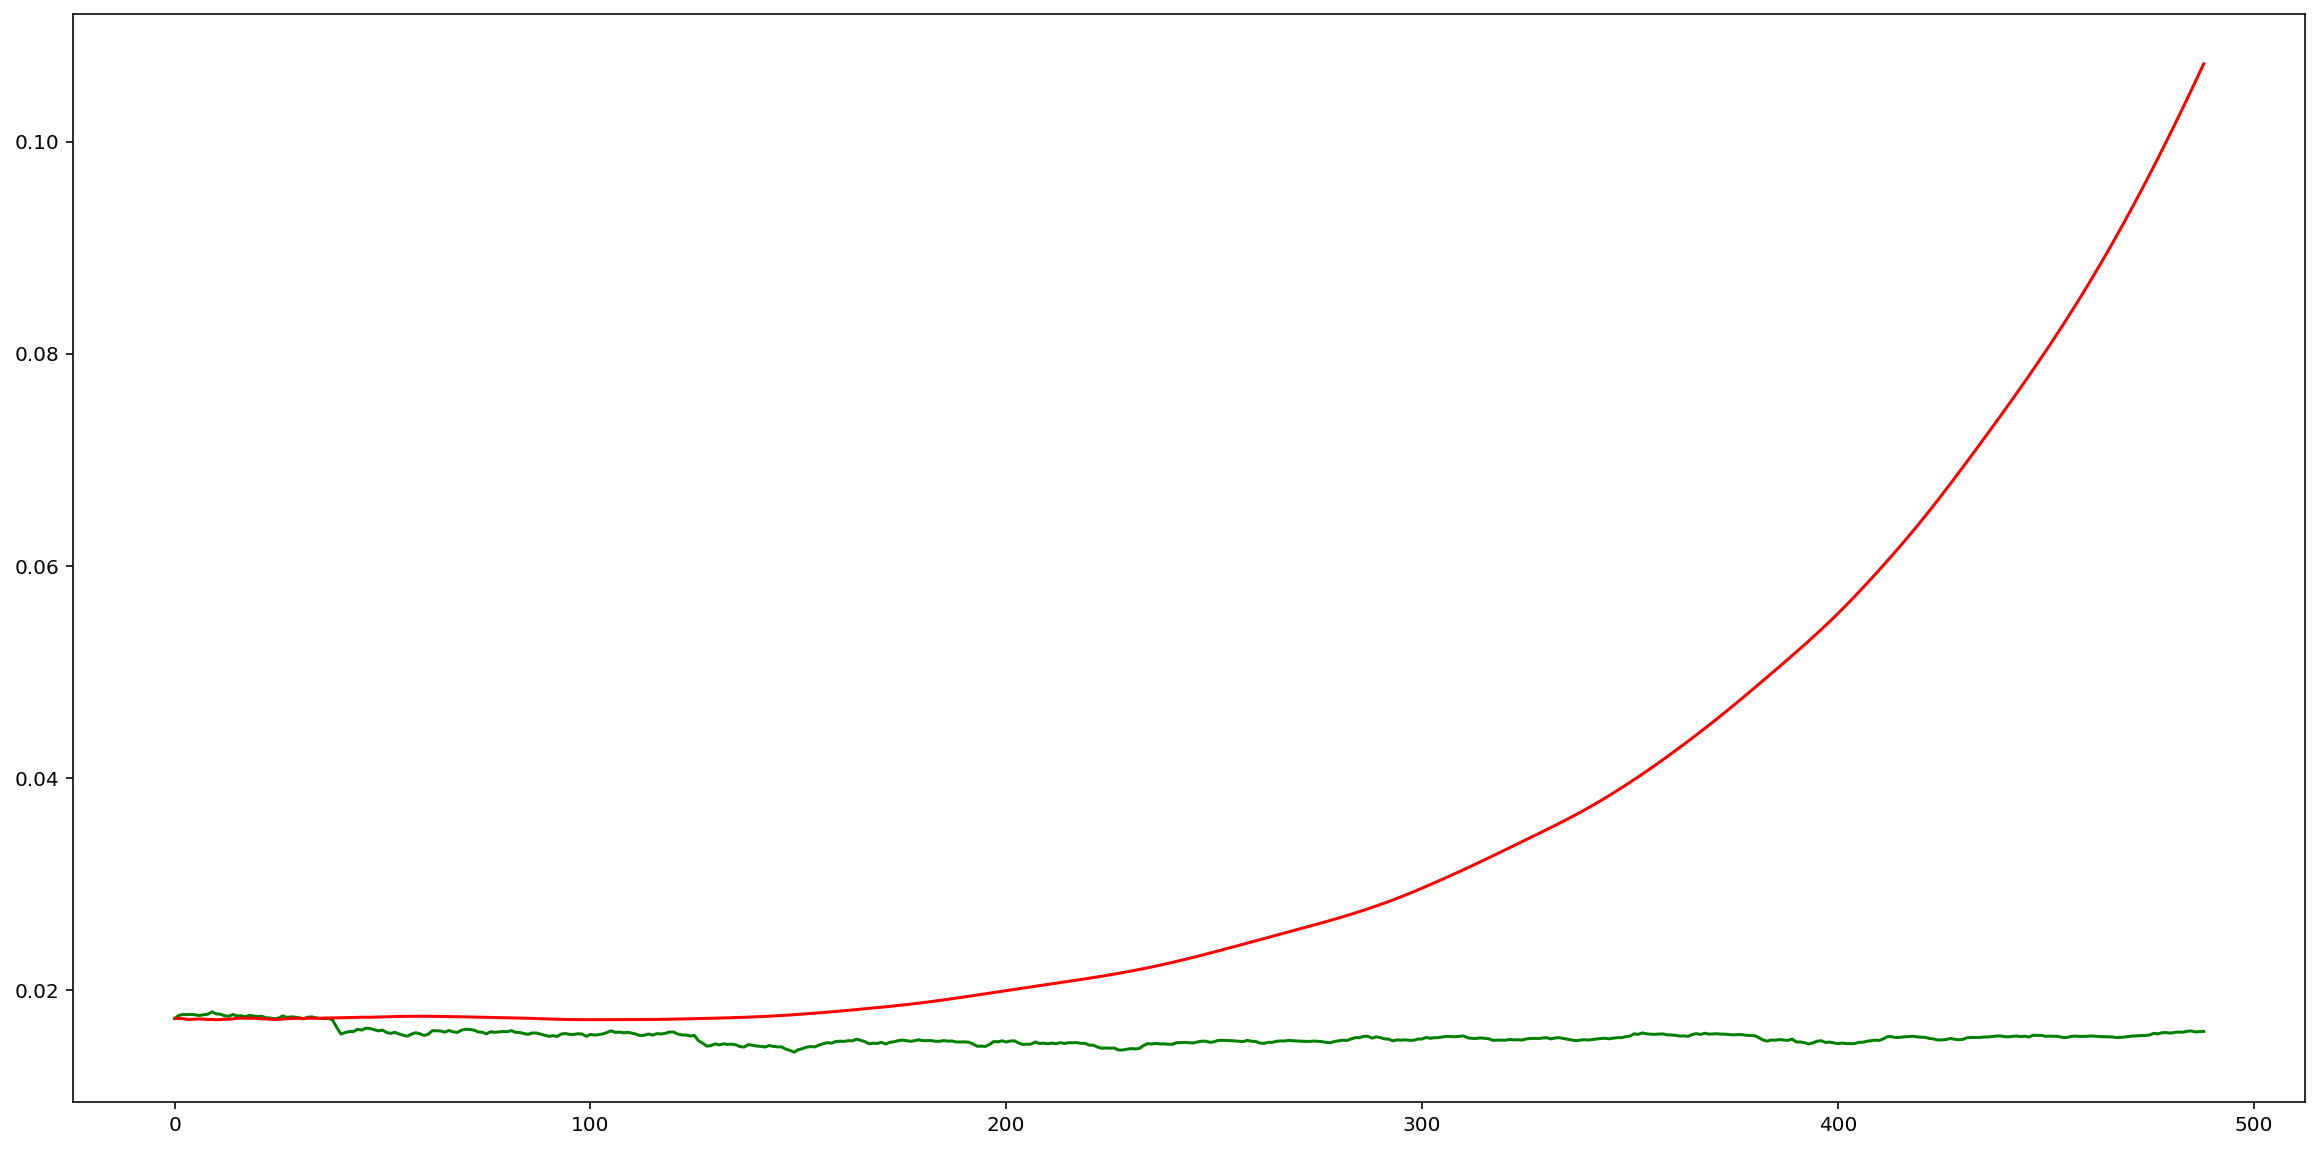

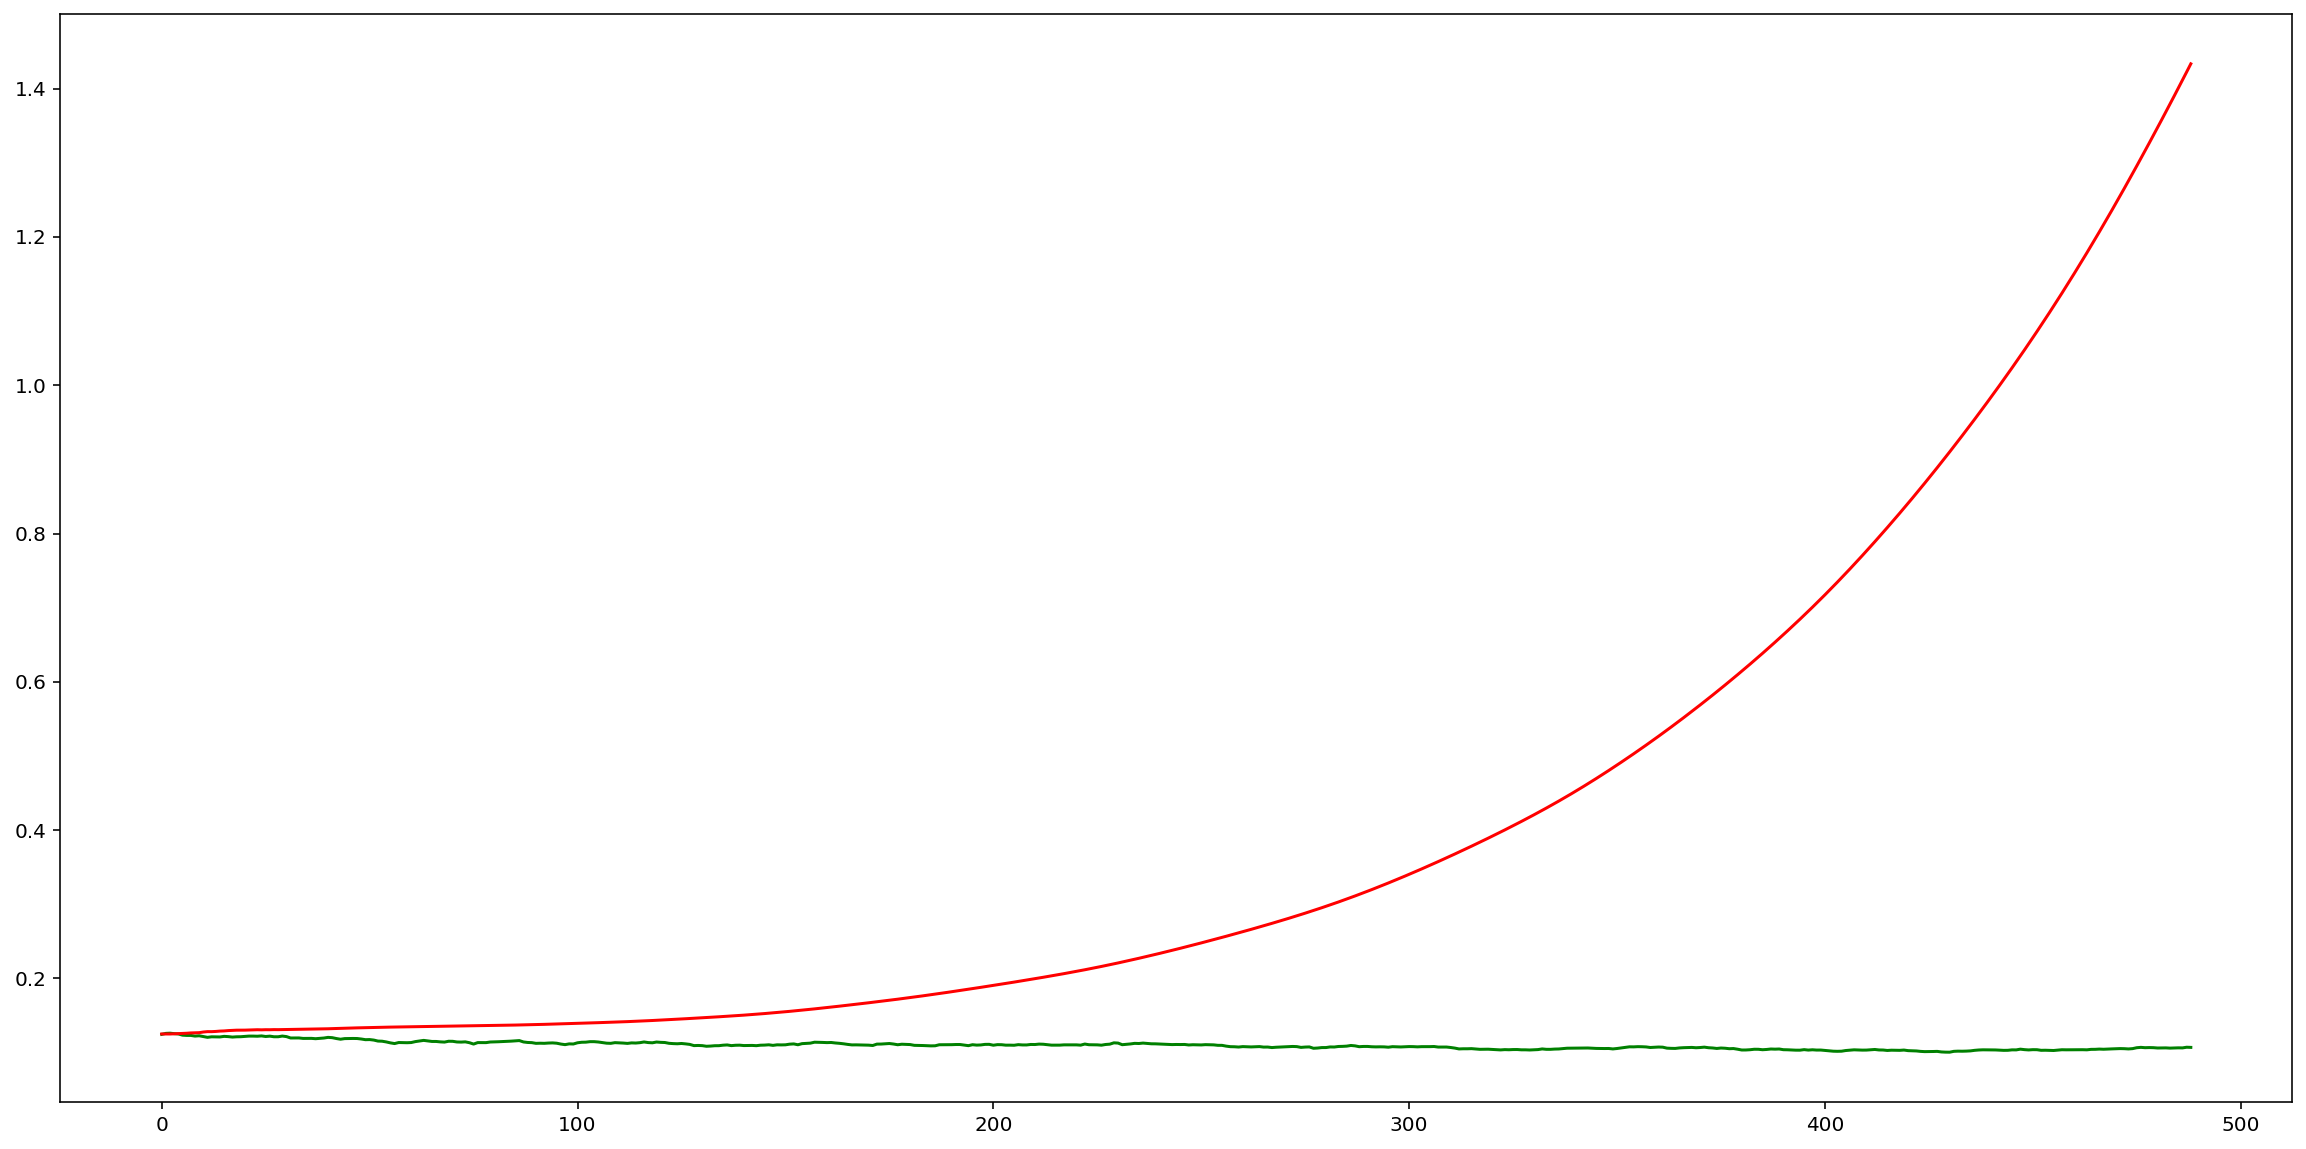

In [0]:
for i in range(n_features):
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(scaler.inverse_transform(test_y[:,0:n_features])[:,i], color='green')
    plt.plot(scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])[:,i], color='red')
    plt.show()

RMSE:

In [0]:
np.square(y_hat - y_pred).mean(axis = 0)

array([3.8525602e-04, 2.2765256e-04, 1.9523970e-04, 2.9958076e-06,
       2.5363847e-06, 2.6011790e-04, 3.6489629e-04, 8.0436095e-08,
       4.2430589e-08, 1.4320309e-08, 6.6205812e-06, 3.6022998e-04,
       3.6015201e-05, 6.6958933e-07, 2.7705386e-05], dtype=float32)

In [0]:
np.square(scaler.inverse_transform(test_y[:,0:n_features]) - scaler.inverse_transform(predict(train_y, len(test_y))[500:500+len(test_y)])).mean(axis=0)

array([2.6834755e+00, 8.9735019e-01, 2.0235190e+00, 1.2881257e-01,
       5.6214072e-02, 4.5067964e+00, 2.3552984e+01, 9.3907345e-04,
       8.4407242e-05, 5.6940302e-05, 3.7426077e-02, 6.7625207e-01,
       4.0467855e-01, 9.1428135e-04, 2.0537511e-01], dtype=float32)